# Master code for plotting and analyzing the DyNetCP model results 

Notebook aggregates the analysis of the results of the unsupervised latent variable model - Dynamic Network Connectivity Predictor (DyNetCP). The Allen Visual Coding Project (VCP) database is used for training and inference of dynamic functional connectivity (Siegle et al. (2021) https://doi.org/10.1038/s41586-020-03171-x

Documentation on the Allen Software Development Kit can be found at https://allensdk.readthedocs.io/en/latest/

In [1]:
import math
import numpy as np
import pandas as pd
import os
import h5py
import collections
from collections import defaultdict
from tqdm import tqdm
import xarray as xr

import matplotlib.pyplot as plt
import matplotlib.animation as animation
from matplotlib import rc
import scipy.stats
from scipy import signal, fftpack
from scipy.ndimage import gaussian_filter1d
rc('animation', html='jshtml')
from mpl_toolkits.axes_grid1 import make_axes_locatable

from allensdk.core.reference_space_cache import ReferenceSpaceCache
reference_space_key = 'annotation/ccf_2017'
resolution = 10


%matplotlib inline

In [2]:
import allensdk
print(allensdk.__version__)

2.13.3


In [3]:
################################################################################
#TODO: Change the manifest path to where you would like it to be
manifest = '/neuropixels/manifest.json'
#################################################################################
rspc = ReferenceSpaceCache(resolution, reference_space_key, manifest=manifest)
rsp = rspc.get_reference_space()
tree = rspc.get_structure_tree(structure_graph_id=1)

In [120]:
################################################################################
# Functions and definitions
################################################################################

def get_sparse_dynamic_wts(st_wts, dyn_wt_dict, send, recv, zero_refractory_offsets=False,
                           recv_spikes=None):
    #print("ST WTS SHAPE: ",st_wts.shape)
    #print("DYN WTS SHAPE: ",dyn_wt_dict[recv][send].shape)
    
    dyn_wts = dyn_wt_dict[recv][send]
    if zero_refractory_offsets:
        print("RUNNING THIS FOR SOME REASON?")
        recv_spikes = recv_spikes[(-len(dyn_wts)):, 1:dyn_wts.shape[1], None] #to align with wts
        dyn_wts[:, 1:] *= 1-recv_spikes #to get refractory
    if st_wts is not None:
        st_wts = st_wts.reshape((1, 1, -1))
        return st_wts + dyn_wts
    else:
        return dyn_wts
    
def get_spikes_for_idx(spikes_path, idx, val_only=False, train_only=False):
    with h5py.File(spikes_path, 'r') as fin:
        if val_only:    
            all_spikes = fin['val'][:, :, idx]
        elif train_only:
            all_spikes = fin['train'][:, :, idx]
        else:
            spikes_train = fin['train'][:, :, idx]
            spikes_val = fin['val'][:, :, idx]
            all_spikes = np.concatenate([spikes_train, spikes_val])
    return all_spikes

def avg_over_send_spikes(spikes, wts, avg_len=0, plot_wt_count=False):
    #spikes is [b, t]
    #wts is [b, t, num_delays]
    result = np.zeros_like(wts)
    counts = np.zeros_like(wts)
    for delay in range(wts.shape[2]):
        if delay == 0:
            result[:, delay:, delay] += spikes*wts[:, :, 0]
            counts[:, :, delay] += spikes
        else:
            result[:, delay:, delay] += spikes[:, :-delay]*wts[:, delay:, delay]
            counts[:, delay:, delay] += spikes[:, :-delay]
    if avg_len > 0:
        final_result = np.copy(result)
        final_counts = np.copy(counts)
        for i in range(1, avg_len):
            final_result[:, i:] += result[:, :-i]
            final_counts[:, i:] += counts[:, :-i]
        result = final_result
        counts = final_counts
    if plot_wt_count:
        return counts.sum(0)
    else:
        return result.sum(0) / (counts.sum(0) + 1e-8)

def get_wt_img_vals(spikes_path, n1, n2, num_delays, static_wts, dyn_offsets, start_time=-150, bin_size=5,
                          plot_start=None, plot_end=None, title=None, trial_num=None, dyn_only=False,
                             subtract_outsides=False, avg_len=0, plot_max=None, shift_wts=0, use_max=False,
                 val_only=False, avg_at_spikes=False, plot_wt_count=False, static_convert=None,
                 plot_info=None, normalize_across_time=False, use_wt_zero_max=True,
                       use_wt_peak=False, delay_avg_len=None, use_gaussian_delay_averaging=False,
                     units=None, id2localidx=None):
    if static_convert is not None:
        s_n1, s_n2 = static_convert[n1], static_convert[n2]
    else:
        s_n1, s_n2 = n1, n2
    seqstdyn_static_0to1 = static_wts[s_n1, s_n2]
    seqstdyn_static_1to0 = static_wts[s_n2, s_n1]
    if dyn_only:
        forward_dyn_wts = get_sparse_dynamic_wts(None, dyn_offsets, n1, n2)
        backward_dyn_wts = get_sparse_dynamic_wts(None, dyn_offsets, n2, n1)
    else:
        forward_dyn_wts = get_sparse_dynamic_wts(seqstdyn_static_0to1, dyn_offsets, n1, n2)
        backward_dyn_wts = get_sparse_dynamic_wts(seqstdyn_static_1to0, dyn_offsets, n2, n1)
    if trial_num is not None:
        forward_dyn_wts = forward_dyn_wts[trial_num]
        backward_dyn_wts = backward_dyn_wts[trial_num]
    elif avg_at_spikes:
        if id2localidx is not None:
            id1, id2 = units.iloc[n1].name, units.iloc[n2].name
            sp_n1 = id2localidx[id1]
            sp_n2 = id2localidx[id2]
        else:
            sp_n1, sp_n2 = n1, n2
        tmp_sp_1 = get_spikes_for_idx(spikes_path, sp_n1, val_only=True)[:, :forward_dyn_wts.shape[1]]
        tmp_sp_2 = get_spikes_for_idx(spikes_path, sp_n2, val_only=True)[:, :forward_dyn_wts.shape[1]]
        forward_dyn_wts = avg_over_send_spikes(tmp_sp_1, forward_dyn_wts, avg_len=avg_len, plot_wt_count=plot_wt_count)
        backward_dyn_wts = avg_over_send_spikes(tmp_sp_2, backward_dyn_wts, avg_len=avg_len, plot_wt_count=plot_wt_count)
    elif use_max:
        forward_dyn_wts = forward_dyn_wts.max(0)
        backward_dyn_wts = backward_dyn_wts.max(0)
    else:
        forward_dyn_wts = forward_dyn_wts.mean(0)
        backward_dyn_wts = backward_dyn_wts.mean(0)
    t = len(forward_dyn_wts)
    if plot_end is None:
        plot_end = t*bin_size
    if plot_start is None:
        plot_start = start_time
    first_bin = int(plot_start - start_time) // bin_size
    last_bin = int(plot_end-start_time) // bin_size
    first_time = start_time + first_bin*bin_size
    last_time = start_time + last_bin*bin_size
    if avg_len > 0 and not avg_at_spikes:
        final_forward = np.copy(forward_dyn_wts)
        final_backward = np.copy(backward_dyn_wts)
        counts = np.ones_like(final_forward)
        for i in range(1, avg_len):
            final_forward[i:] += forward_dyn_wts[:-i]
            final_backward[i:] += backward_dyn_wts[:-i]
            counts[i:] += 1
        if plot_wt_count:
            forward_dyn_wts = counts
            backward_dyn_wts = counts
        else:
            forward_dyn_wts = final_forward / counts
            backward_dyn_wts = final_backward / counts
    forward_dyn_wts = forward_dyn_wts[first_bin:last_bin]
    backward_dyn_wts = backward_dyn_wts[first_bin:last_bin]
    forward_dyn_wts = np.copy(forward_dyn_wts)
    final_result = np.concatenate([np.flip(forward_dyn_wts.T, (0,)), backward_dyn_wts[:, 1:].T])
    
    if delay_avg_len is not None:
        if use_gaussian_delay_averaging:
            final_result = gaussian_filter1d(final_result, delay_avg_len, axis=0, mode='nearest')
        else:
            tmp_result = np.empty((len(final_result)+2*delay_avg_len, final_result.shape[1]))
            tmp_result[:delay_avg_len] = final_result[0]
            tmp_result[-delay_avg_len:] = final_result[-1]
            tmp_result[delay_avg_len:-delay_avg_len] = final_result
            final_tmp_result = np.zeros_like(tmp_result)
            for idx in range(delay_avg_len, len(final_tmp_result)-delay_avg_len):
                final_tmp_result[idx] = tmp_result[idx-delay_avg_len:idx+delay_avg_len+1].mean(0)
            final_result = final_tmp_result[delay_avg_len:-delay_avg_len]
    
    return final_result, forward_dyn_wts, backward_dyn_wts

def compute_sig_for_wts(static_wts, n1, n2, final_result, forward_dyn_wts, backward_dyn_wts, 
                        normalize_across_time=True,
                        use_wt_peak=False, static_convert=None, delay_ind=None,
                        plot_std_units=False):   
    out_len = forward_dyn_wts.shape[1]//2
    outsides = np.concatenate([final_result[:out_len], final_result[-out_len:]])
    if normalize_across_time:
        means = outsides.mean(keepdims=True)
        stds = outsides.std(keepdims=True)+1e-8
    else:
        means = outsides.mean(0, keepdims=True)
        stds = outsides.std(axis=0, keepdims=True)+1e-8
    
    if delay_ind is not None:
        all_wts = np.concatenate([np.flip(forward_dyn_wts.T, (0,)), backward_dyn_wts.T[1:]])
        if plot_std_units:
            wt_plot_vals = ((all_wts - means)/stds)
        else:
            wt_plot_vals = all_wts
        wt_plot_vals = wt_plot_vals[delay_ind + forward_dyn_wts.shape[1]-1]
    elif use_wt_peak:
        if plot_std_units:
            wt_plot_vals = ((forward_dyn_wts.T - means)/stds)
        else:
            wt_plot_vals = forward_dyn_wts.T
        wt_plot_vals = wt_plot_vals[:-out_len]
        if static_convert is not None:
            s_n1, s_n2 = static_convert[n1], static_convert[n2]
        else:
            s_n1, s_n2 = n1, n2
        seqstdyn_static_0to1 = static_wts[s_n1, s_n2]
        seqstdyn_static_1to0 = static_wts[s_n2, s_n1]
        delay_ind = np.abs(seqstdyn_static_0to1[:out_len+1]).argmax()
        wt_plot_vals = wt_plot_vals[delay_ind]
    
    else:
        if plot_std_units:
            wt_plot_vals = ((forward_dyn_wts.T - means)/stds)
        else:
            wt_plot_vals = forward_dyn_wts.T
        wt_plot_vals = wt_plot_vals[:-out_len]
        wt_plot_vals = wt_plot_vals.max(axis=0)
    return wt_plot_vals

def plot_all_dyn_pairs_pts_static(static_wts, dyn_offsets, figsize=None, max_size=None,
                              structures=None, structure_names=None, struct_order=None, pairs=None,
                                 pair_colors=None, n_convert=None, min_n1=None, max_n1=None, min_n2=None, 
                                  max_n2=None, pair2stdynratio=None, pair2maxdynval=None, pair2maxdynoffset=None,
                                  st_dyn_ratio_threshold=None, max_dyn_val_threshold=None,
                                 max_dyn_offset_threshold=None, filtered_indices=[]):
    if struct_order is not None:
        struct_counts = {s:sum(structures == s) for s in structure_names}
        local_idx = []
        past_struct = None
        past_count = 0
        for n,struct in enumerate(structures):
            if struct != past_struct:
                past_struct = struct
                past_count = 0
            local_idx.append(past_count)
            past_count += 1
        new_offsets_sum = np.cumsum(np.array([struct_counts[s] for s in struct_order]))
        new_offsets = collections.OrderedDict()
        for s, val in zip(struct_order, np.concatenate([np.array([0]), new_offsets_sum[:-1]])):
            new_offsets[s] = val
        
        new_n_convert = collections.OrderedDict()
        for i, s in enumerate(structures):
            new_n_convert[i] = local_idx[i]+new_offsets[s]
        if n_convert is None:
            n_convert = new_n_convert
        else:
            orig_n_convert = n_convert
            n_convert = collections.OrderedDict()
            for i in orig_n_convert.keys():
                n_convert[i] = new_n_convert[orig_n_convert[i]]
        struct_names = struct_order
    all_send = []
    all_recv = []
    num_neurons = len(structures)
    all_rates = []
    all_colors = []
    for recv in dyn_offsets:
        if recv not in n_convert:
            continue # we do not plot this neuron
        if (min_n2 is not None and recv < min_n2) or (max_n2 is not None and recv > max_n2):
            continue
        elif recv in filtered_indices:
            continue
        for send in dyn_offsets[recv]:
            if pairs is not None and [send, recv] not in pairs.tolist():
                continue
            if send not in n_convert:
                continue # we do not plot this neuron
            if (min_n1 is not None and send < min_n1) or (max_n1 is not None and send > max_n1):
                continue
            elif send in filtered_indices:
                continue
            elif st_dyn_ratio_threshold is not None and pair2stdynratio[(send, recv)] < st_dyn_ratio_threshold:
                continue
            elif max_dyn_val_threshold is not None and pair2maxdynval[(send, recv)] < max_dyn_val_threshold:
                continue
            elif max_dyn_offset_threshold is not None and pair2maxdynoffset[(send, recv)] < max_dyn_offset_threshold:
                continue
            st_wt = static_wts[send, recv]
           
            dyn_wts = dyn_offsets[recv][send]
        
            st_ind = st_wt.argmax()
           
            
            all_send.append(n_convert[send])
            all_recv.append(n_convert[recv])
            if pair_colors is not None:
                all_colors.append(pair_colors[(send, recv)])
    fig, ax = plt.subplots(figsize=figsize)
    #im = ax.imshow(all_wts[0])
    if structures is not None:
        #valid_structures = ['VISam','VISpm','VISp', 'VISl', 'VISal', 'VISrl']
        if min_n1 is not None:
            valid_structures_y = structure_names[min_n1:max_n1]
            valid_structures_x = structure_names[min_n2:max_n2]
        else:
            valid_structures_x = valid_structures_y = structure_names
        valid_structures = struct_order
        struct_counts = [np.sum(structures == s) for s in valid_structures]
        struct_cumsum = np.cumsum(struct_counts)
    if layers is not None:
        if min_n1 is not None:
            valid_layers_y = layers[min_n1:max_n1]
            valid_layers_x = layers[min_n2:max_n2]
        else:
            valid_layers_x = valid_layers_y = layers
        valid_layers = []
        layer_counts = []
        current_layer = None
        for l in layers:
            if l != current_layer:
                if current_layer is not None:
                    layer_counts.append(current_count)
                valid_layers.append(l)
                current_layer = l
                current_count = 1
            else:
                current_count += 1
        layer_counts.append(current_count)
        layer_cumsum = np.cumsum(layer_counts)
        
    if structures is not None:
        prev_loc = 0
        if min_n1 is not None:
            name_y_loc = min_n1 - 25
        else:
            name_y_loc = -25
        if min_n2 is not None:
            name_x_loc = min_n2 - 30
        else:
            name_x_loc = -30
        if invert:
            f_valid_structures = np.flip(valid_structures, (-1,))
            f_struct_counts = np.flip(struct_counts, (-1,))
            #f_struct_cumsum = np.flip(struct_cumsum, (-1,))
            f_struct_cumsum = np.cumsum(f_struct_counts)
        else:
            f_valid_structures = valid_structures
            f_struct_counts = struct_counts
            f_struct_cumsum = struct_cumsum
        for struct, s_count, s_cumsum in zip(f_valid_structures, f_struct_counts, f_struct_cumsum):
            if s_count > 0:
                if min_n2 is None or (prev_loc+s_count > min_n2 and prev_loc < max_n2):
                    #tmp_xloc = prev_loc+1
                    tmp_xloc = 0.1 + 0.8*((s_cumsum - s_count) / struct_cumsum[-1])
                    if min_n2 is not None:
                        #tmp_xloc = max(tmp_xloc, min_n2+1)
                        tmp_xloc = max(0.1+0.8*((s_cumsum - s_count - min_n2)/(max_n2 - min_n2)), 0.1)
                    #ax.text(tmp_xloc, name_y_loc, struct)
                    fig.text(tmp_xloc, 0, struct)
                if min_n1 is None or (prev_loc+s_count > min_n1 and prev_loc < max_n1):
                    #tmp_yloc = prev_loc+1
                    tmp_yloc = 0.1 + 0.8*((s_cumsum - s_count) / struct_cumsum[-1])
                    if min_n1 is not None:
                        #tmp_yloc = max(tmp_yloc, min_n1+1)
                        tmp_yloc = max(0.1+0.8*((s_cumsum - s_count - min_n1) / (max_n1 - min_n1)), 0.1)
                    #ax.text(name_x_loc, tmp_yloc, struct)
                    fig.text(0, tmp_yloc, struct)
                prev_loc = s_cumsum
############################################################################################
    #all_wts = (st_wt - shared_threshold).clip(min=0)
    #all_wts = np.stack(st_wt, axis=-1)
    #all_wts = st_wt
    #print(st_wt)
    #overall_max = all_wts.max(axis=0, keepdims=True)
    #all_sizes = max_size*all_wts/overall_max
    #print("all_sizes: ", len(all_sizes))
    #print("all_recv: ", len(all_recv))
    #sc = ax.scatter(all_recv, all_send, s=all_sizes, facecolors='none', edgecolors=all_colors, alpha=0.85)
    sc = ax.scatter(all_recv, all_send, s=max_size, facecolors='none', edgecolors=all_colors)
###########################################################################################
    annot = ax.annotate("", xy=(0,0), xytext=(20,20),textcoords="offset points",
                    bbox=dict(boxstyle="round", fc="w"),
                    arrowprops=dict(arrowstyle="->"))
    annot.set_visible(False)
    def update_annot(ind):

        pos = sc.get_offsets()[ind["ind"][0]]
        annot.xy = pos
        #text = "{}".format(" ".join(pos))
        text = "{}, {}".format(" ".join(list(map(str,ind["ind"]))))
        print("NEW TEXT: ",text)
        print("POS: ",pos)
        annot.set_text(text)
        #annot.get_bbox_patch().set_facecolor(cmap(norm(c[ind["ind"][0]])))
        annot.get_bbox_patch().set_alpha(0.4)
    def hover(event):
        vis = annot.get_visible()
        print("RUNNING EVENT!!!")
        if event.inaxes == ax:
            cont, ind = sc.contains(event)
            if cont:
                update_annot(ind)
                annot.set_visible(True)
                fig.canvas.draw_idle()
            else:
                if vis:
                    annot.set_visible(False)
                    fig.canvas.draw_idle()
    fig.canvas.mpl_connect("motion_notify_event", hover)
    if structures is not None:
            prev_loc = 0
            if min_n1 is not None:
                name_y_loc = min_n1 - 25
            else:
                name_y_loc = -25
            if min_n2 is not None:
                name_x_loc = min_n2 - 30
            else:
                name_x_loc = -30
            for struct, s_count, s_cumsum in zip(valid_structures, struct_counts, struct_cumsum):
                if s_count > 0:
                    if prev_loc > 0:
                        #if (min_n2 is None or prev_loc > min_n2) and (max_n2 is None or prev_loc < max_n2):
                        ax.plot([0, num_neurons], [prev_loc, prev_loc], linestyle='--', color='k')
                        #if (min_n1 is None or prev_loc > min_n1) and (max_n1 is None or prev_loc < max_n1):
                        ax.plot([prev_loc, prev_loc], [0, num_neurons], linestyle='--', color='k')
                    prev_loc = s_cumsum
    if layers is not None:
        prev_loc = 0
        if min_n1 is not None:
            name_y_loc = min_n1 - 25
        else:
            name_y_loc = -25
        if min_n2 is not None:
            name_x_loc = min_n2 - 30
        else:
            name_x_loc = -30
        for struct, s_count, s_cumsum in zip(valid_layers, layer_counts, layer_cumsum):
            if s_count > 0:
                if prev_loc > 0:
                    #if (min_n2 is None or prev_loc > min_n2) and (max_n2 is None or prev_loc < max_n2):
                    ax.plot([0, num_neurons], [prev_loc, prev_loc], linestyle='dotted', color='k')
                    #if (min_n1 is None or prev_loc > min_n1) and (max_n1 is None or prev_loc < max_n1):
                    ax.plot([prev_loc, prev_loc], [0, num_neurons], linestyle='dotted', color='k')
                prev_loc = s_cumsum
    if min_n2 is not None:
        ax.set_xlim(min_n2, max_n2)
    else:
        ax.set_xlim(0, num_neurons)
    if min_n1 is not None:
        ax.set_ylim(min_n1, max_n1)
    else:
        ax.set_ylim(0, num_neurons)
    output_convert = collections.OrderedDict()
    for k,v in n_convert.items():
        output_convert[v] = k
    return fig, ax, output_convert
    

def plot_all_dyn_pairs_pts_sig(static_wts, dyn_offsets, max_time=400, interval=100, figsize=None,
                       only_offsets=False, min_val=-2, max_val=2, max_size=3, changing_only=False,
                          start_bin=0, only_positive=False, start_time=0, return_frame=None,
                          min_n1=None, max_n1=None, min_n2=None, max_n2=None, structures=None,
                          structure_names=None, add_rate_plot=False, spike_rates=None,
                          independently_normalize_spike_rates=False, max_spike_rate_size=3,
                              avg_at_spikes=False, normalize_per_pair=False, base_spikes_path=None,
                              avg_len=0, num_delays=10, pair_colors=None, invert=False, layers=None,
                              filtered_indices=set(), struct_order=None, use_threshold_per_pair=False,
                              per_pair_threshold_ratio=0.5, n_convert=None, pair2session=None,
                              units=None, id2localidx=None, shared_threshold=None, 
                               plot_offsets=False, pair2stdynratio=None, pair2maxdynval=None,
                               pair2maxdynoffset=None,
                                  st_dyn_ratio_threshold=None, max_dyn_val_threshold=None,
                                 max_dyn_offset_threshold=None, plot_pairs=[]):
    if struct_order is not None:
        struct_counts = {s:sum(structures == s) for s in structure_names}
        local_idx = []
        past_struct = None
        past_count = 0
        for n,struct in enumerate(structures):
            if struct != past_struct:
                past_struct = struct
                past_count = 0
            local_idx.append(past_count)
            past_count += 1
        new_offsets = np.cumsum(np.array([struct_counts[s] for s in struct_order]))
        new_offsets = {s:val for s, val in zip(struct_order, np.concatenate([np.array([0]), new_offsets[:-1]]))}
        new_n_convert = {i:local_idx[i]+new_offsets[s] for i,s in enumerate(structures)}
        if n_convert is None:
            n_convert = new_n_convert
        else:
            n_convert = {i:new_n_convert[n_convert[i]] for i in n_convert.keys()}
        struct_names = struct_order
    elif n_convert is None:
        n_convert = {i:i for i in range(len(structures))}
    #all_wts = np.zeros((max_time, len(static_wts), len(static_wts)))
    all_send = []
    all_recv = []
    all_wts = []
    #num_neurons = len(static_wts)
    num_neurons = len(structures)
    all_rates = []
    all_colors = []
    for send, recv in plot_pairs:
        if recv not in n_convert:
            continue # we do not plot this neuron
        if (min_n2 is not None and recv < min_n2) or (max_n2 is not None and recv > max_n2):
            continue
        elif recv in filtered_indices:
            continue
        if send not in n_convert:
            continue # we do not plot this neuron
        if (min_n1 is not None and send < min_n1) or (max_n1 is not None and send > max_n1):
            continue
        elif send in filtered_indices:
            continue
        elif st_dyn_ratio_threshold is not None and pair2stdynratio[(send, recv)] < st_dyn_ratio_threshold:
            continue
        elif max_dyn_val_threshold is not None and pair2maxdynval[(send, recv)] < max_dyn_val_threshold:
            continue
        elif max_dyn_offset_threshold is not None and pair2maxdynoffset[(send, recv)] < max_dyn_offset_threshold:
            continue
        st_wt = static_wts[send, recv]
        if plot_offsets:
            delay_ind = - np.argmax(st_wt)
            #print("units:"%([send, recv]),"Time lag of max"%(delay_ind)
            #print("DELAY IND: ",delay_ind)
            
        else:
            delay_ind=None
        dyn_wts = dyn_offsets[recv][send]
        sess = pair2session[(send, recv)]
        spikes_path = base_spikes_path % sess
        st_ind = st_wt.argmax()
        #dyn_wts = dyn_wts[:, :, st_ind].mean(0)
        wt_im, wt_f_vals, wt_b_vals = get_wt_img_vals(spikes_path, send, recv, num_delays, static_wts, dyn_offsets, 
                                              avg_len=avg_len, avg_at_spikes=avg_at_spikes,
                                              static_convert=None, id2localidx=id2localidx,
                                                     units=units, dyn_only=plot_offsets,
                                                     )


        wt_sig = compute_sig_for_wts(static_wts, send, recv, wt_im, wt_f_vals, wt_b_vals, 
                                     normalize_across_time=True,
                                     use_wt_peak=True, static_convert=None, delay_ind=delay_ind)
        #if changing_only:
        #    pos = np.sum(dyn_wts > 0) > 10
        #    neg = np.sum(dyn_wts < 0) > 10
        #    if not (pos and neg):
        #        continue
        all_wts.append(wt_sig)
        all_send.append(n_convert[send])
        all_recv.append(n_convert[recv])
        if add_rate_plot:
            all_rates.append(spike_rates[n_convert[recv]][n_convert[send]])
        if pair_colors is not None:
            all_colors.append(pair_colors[(send, recv)])
    
    all_wts = np.stack(all_wts, axis=-1)
    print("ALL WTS SHAPE: ",all_wts.shape)
    #all_wts = all_wts.clip(min_val, max_val)

    if use_threshold_per_pair:
        all_wts = all_wts.clip(min=0)
        all_mins = all_wts.min(axis=0, keepdims=True)
        all_maxes = all_wts.max(axis=0, keepdims=True)
        if shared_threshold is not None:
            thresholds = shared_threshold
        else:
            thresholds = (all_maxes - all_mins)*per_pair_threshold_ratio
            thresholds = thresholds.clip(min=0)
        all_sizes = (all_wts - thresholds).clip(min=0)
        overall_max = all_sizes.max(axis=0, keepdims=True)
        all_sizes = max_size * all_sizes / overall_max
    else:
        if shared_threshold is not None:
            all_wts = (all_wts - shared_threshold).clip(min=0)
        else:
            all_wts = all_wts.clip(min=0)
        #overall_max = all_wts.max()
        overall_max = all_wts.max(axis=0, keepdims=True)
        all_sizes = max_size*all_wts/overall_max
    if add_rate_plot:
        fig, [ax, ax2] = plt.subplots(1, 2, figsize=[2*figsize[0], figsize[1]])
        all_rates = np.stack(all_rates, axis=-1)
        if independently_normalize_spike_rates:
            
            all_rate_sizes = max_spike_rate_size*(all_rates)/all_rates[start_bin:max_time].max(0, keepdims=True)
        else:
            all_rate_sizes = max_spike_rate_size*(all_rates)/all_rates.max()
    else:
        fig, ax = plt.subplots(figsize=figsize)
    #im = ax.imshow(all_wts[0])
    if structures is not None:
        #valid_structures = ['VISam','VISpm','VISp', 'VISl', 'VISal', 'VISrl']
        if min_n1 is not None:
            valid_structures_y = structure_names[min_n1:max_n1]
            valid_structures_x = structure_names[min_n2:max_n2]
        else:
            valid_structures_x = valid_structures_y = structure_names
        valid_structures = struct_order
        struct_counts = [np.sum(structures == s) for s in valid_structures]
        struct_cumsum = np.cumsum(struct_counts)
    if layers is not None:
        if min_n1 is not None:
            valid_layers_y = layers[min_n1:max_n1]
            valid_layers_x = layers[min_n2:max_n2]
        else:
            valid_layers_x = valid_layers_y = layers
        valid_layers = []
        layer_counts = []
        current_layer = None
        for l in layers:
            if l != current_layer:
                if current_layer is not None:
                    layer_counts.append(current_count)
                valid_layers.append(l)
                current_layer = l
                current_count = 1
            else:
                current_count += 1
        layer_counts.append(current_count)
        layer_cumsum = np.cumsum(layer_counts)
        
    if structures is not None:
        prev_loc = 0
        if min_n1 is not None:
            name_y_loc = min_n1 - 25
        else:
            name_y_loc = -25
        if min_n2 is not None:
            name_x_loc = min_n2 - 30
        else:
            name_x_loc = -30
        if invert:
            f_valid_structures = np.flip(valid_structures, (-1,))
            f_struct_counts = np.flip(struct_counts, (-1,))
            #f_struct_cumsum = np.flip(struct_cumsum, (-1,))
            f_struct_cumsum = np.cumsum(f_struct_counts)
        else:
            f_valid_structures = valid_structures
            f_struct_counts = struct_counts
            f_struct_cumsum = struct_cumsum
        for struct, s_count, s_cumsum in zip(f_valid_structures, f_struct_counts, f_struct_cumsum):
            if s_count > 0:
                if min_n2 is None or (prev_loc+s_count > min_n2 and prev_loc < max_n2):
                    #tmp_xloc = prev_loc+1
                    tmp_xloc = 0.1 + 0.8*((s_cumsum - s_count) / struct_cumsum[-1])
                    if min_n2 is not None:
                        #tmp_xloc = max(tmp_xloc, min_n2+1)
                        tmp_xloc = max(0.1+0.8*((s_cumsum - s_count - min_n2)/(max_n2 - min_n2)), 0.1)
                    #ax.text(tmp_xloc, name_y_loc, struct)
                    fig.text(tmp_xloc, 0, struct)
                if min_n1 is None or (prev_loc+s_count > min_n1 and prev_loc < max_n1):
                    #tmp_yloc = prev_loc+1
                    tmp_yloc = 0.1 + 0.8*((s_cumsum - s_count) / struct_cumsum[-1])
                    if min_n1 is not None:
                        #tmp_yloc = max(tmp_yloc, min_n1+1)
                        tmp_yloc = max(0.1+0.8*((s_cumsum - s_count - min_n1) / (max_n1 - min_n1)), 0.1)
                    #ax.text(name_x_loc, tmp_yloc, struct)
                    fig.text(0, tmp_yloc, struct)
                prev_loc = s_cumsum
    def plot_frame(fr):
        #im.set_data(all_wts[fr])
        ax.clear()
        #ax.imshow(all_wts[fr], vmin=min_val, vmax=max_val, cmap='bwr')
        colors = []
        orig_fr = fr
        fr = fr + start_bin
        current_recv = []
        current_send = []
        current_sizes = []
        for size, send, recv, val in zip(all_sizes[fr], all_send, all_recv, all_wts[fr]):
            if val > 0:
                #colors.append('r')
                current_recv.append(recv)
                current_send.append(send)
                current_sizes.append(size)
            elif not only_positive:
                #colors.append('b')
                current_recv.append(recv)
                current_send.append(send)
                current_sizes.append(size)
        ax.scatter(current_recv, current_send, s=current_sizes, facecolors='none', edgecolors=all_colors)
        if min_n2 is not None:
            ax.set_xlim(min_n2, max_n2)
        else:
            ax.set_xlim(0, num_neurons)
        if min_n1 is not None:
            ax.set_ylim(min_n1, max_n1)
        else:
            ax.set_ylim(0, num_neurons)
        #ax.set_title('Frame %d'%(orig_fr + start_time))
        ax.set_title("Time (ms) %d"%(orig_fr*5 + start_time), fontsize=16)
        if structures is not None:
            prev_loc = 0
            if min_n1 is not None:
                name_y_loc = min_n1 - 25
            else:
                name_y_loc = -25
            if min_n2 is not None:
                name_x_loc = min_n2 - 30
            else:
                name_x_loc = -30
            for struct, s_count, s_cumsum in zip(valid_structures, struct_counts, struct_cumsum):
                if s_count > 0:
                    if prev_loc > 0:
                        #if (min_n2 is None or prev_loc > min_n2) and (max_n2 is None or prev_loc < max_n2):
                        ax.plot([0, num_neurons], [prev_loc, prev_loc], linestyle='-', color='silver', linewidth=1)
                        #if (min_n1 is None or prev_loc > min_n1) and (max_n1 is None or prev_loc < max_n1):
                        ax.plot([prev_loc, prev_loc], [0, num_neurons], linestyle='-', color='silver', linewidth=1)
                    '''
                    if min_n2 is None or (prev_loc+s_count > min_n2 and prev_loc < max_n2):
                        #tmp_xloc = prev_loc+1
                        tmp_xloc = (s_cumsum - s_count) / struct_cumsum[-1]
                        if min_n2 is not None:
                            #tmp_xloc = max(tmp_xloc, min_n2+1)
                            tmp_xloc = max((s_cumsum - s_count - min_n2)/(max_n2 - min_n2), 0.1)
                        #ax.text(tmp_xloc, name_y_loc, struct)
                        fig.text(tmp_xloc, 0, struct)
                    if min_n1 is None or (prev_loc+s_count > min_n1 and prev_loc < max_n1):
                        #tmp_yloc = prev_loc+1
                        tmp_yloc = (s_cumsum - s_count) / struct_cumsum[-1]
                        if min_n1 is not None:
                            #tmp_yloc = max(tmp_yloc, min_n1+1)
                            tmp_yloc = max((s_cumsum - s_count - min_n1) / (max_n1 - min_n1), 0.1)
                        #ax.text(name_x_loc, tmp_yloc, struct)
                        fig.text(0, tmp_yloc, struct)
                    '''
                    prev_loc = s_cumsum
        if layers is not None:
            prev_loc = 0
            if min_n1 is not None:
                name_y_loc = min_n1 - 25
            else:
                name_y_loc = -25
            if min_n2 is not None:
                name_x_loc = min_n2 - 30
            else:
                name_x_loc = -30
            for struct, s_count, s_cumsum in zip(valid_layers, layer_counts, layer_cumsum):
                if s_count > 0:
                    if prev_loc > 0:
                        #if (min_n2 is None or prev_loc > min_n2) and (max_n2 is None or prev_loc < max_n2):
                        ax.plot([0, num_neurons], [prev_loc, prev_loc], linestyle='dotted', color='k')
                        #if (min_n1 is None or prev_loc > min_n1) and (max_n1 is None or prev_loc < max_n1):
                        ax.plot([prev_loc, prev_loc], [0, num_neurons], linestyle='dotted', color='k')
                    prev_loc = s_cumsum
        if add_rate_plot:
            colors = []
            current_recv = []
            current_send = []
            current_sizes = []
            ax2.clear()
            for size, send, recv in zip(all_rate_sizes[fr], all_send, all_recv):
                colors.append('r')
                current_recv.append(recv)
                current_send.append(send)
                current_sizes.append(size)
            ax2.scatter(current_recv, current_send, s=current_sizes, c=colors)
            if min_n2 is not None:
                ax2.set_xlim(min_n2, max_n2)
            else:
                ax2.set_xlim(0, num_neurons)
            if min_n1 is not None:
                ax2.set_ylim(min_n1, max_n1)
            else:
                ax2.set_ylim(0, num_neurons)
            if structures is not None:
                prev_loc = 0
                for struct, s_count, s_cumsum in zip(valid_structures, struct_counts, struct_cumsum):
                    if s_count > 0:
                        if prev_loc > 0:
                            ax2.plot([0, num_neurons], [prev_loc, prev_loc], linestyle='--', color='k')
                            ax2.plot([prev_loc, prev_loc], [0, num_neurons], linestyle='--', color='k')

                        ax2.text(prev_loc+5, -25, struct)
                        ax2.text(-30, prev_loc+5, struct)
                        prev_loc = s_cumsum
        if invert:
            plt.gca().invert_xaxis()
            plt.gca().invert_yaxis()
    if return_frame is not None:
        plot_frame(return_frame-start_time)
        return fig
    else:
        anim = animation.FuncAnimation(fig, plot_frame, interval=interval, frames = max_time-start_bin)
        return anim
    
def create_shuffled_data(data, shuffle_width=25, seed=1):
    np.random.seed(seed)
    # data is [ntrials, ntimesteps]
    M, t = data.shape
    rem = t%shuffle_width
    result = np.zeros_like(data)
    for start_ind in np.arange(0, t, shuffle_width):
        b_inds, sp_inds = data[:, start_ind:start_ind+shuffle_width].nonzero()
        np.random.shuffle(sp_inds)
        result[b_inds, sp_inds+start_ind] = 1
    return result

def nextpow2(x):
    if x == 0:
        y = 0
    else:
        y = math.ceil(math.log2(x))
    return y

def xcorr(x, y, maxlag):
    m = max(len(x), len(y))
    mx1 = min(maxlag, m - 1)
    ceilLog2 = nextpow2(2 * m - 1)
    m2 = 2 ** ceilLog2

    X = fftpack.fft(x, m2)
    Y = fftpack.fft(y, m2)
    c1 = np.real(fftpack.ifft(X * np.conj(Y)))
    index1 = np.arange(1, mx1+1, 1) + (m2 - mx1 -1)
    index2 = np.arange(1, mx1+2, 1) - 1
    c = np.hstack((c1[index1], c1[index2]))
    return c

def compute_ccg(n1, n2, ccg_len=100, bin_size=0.001):
    #n1, n2 should be [ntrials, ntimesteps] binned trial data
    all_corr = np.zeros(2*ccg_len+1)
    M, t = n1.shape
    r1 = n1.mean()
    r2 = n2.mean()
    mid = t-1
    for trial in range(len(n1)):
        new_corr = xcorr(n1[trial], n2[trial], ccg_len)
        all_corr += new_corr
    all_corr = all_corr/(M*np.sqrt(r1*r2))
    triang = t - np.abs(np.arange(-ccg_len, ccg_len+0.5))
    all_corr /= triang
    return all_corr

def compute_shuffled_ccg(n1, n2, ntrials, ccg_len=100, bin_size=0.001):
    total_ccg = np.zeros(2*ccg_len+1)
    shuffle_time = 0
    ccg_time = 0
    import time
    for trial in range(ntrials):
        start = time.time()
        s_n1 = create_shuffled_data(n1, seed=trial)
        s_n2 = create_shuffled_data(n2, seed=trial)
        end = time.time()
        shuffle_time += (end-start)
        start = time.time()
        ccg = compute_ccg(s_n1, s_n2, ccg_len=ccg_len, bin_size=bin_size)
        end = time.time()
        ccg_time += (end-start)
        total_ccg += ccg
    return total_ccg/ntrials

def plot_ccg(ccg, ccg_len=100, bin_size=0.001, max_len=None):
    x = np.arange(-ccg_len*bin_size, ccg_len*bin_size+bin_size/2, bin_size)*1000
    if max_len is not None:
        x = x[ccg_len-max_len:ccg_len+max_len+2]
        ccg = ccg[ccg_len-max_len:ccg_len+max_len+2]
    fig, ax = plt.subplots()
    ax.plot(x, ccg)
    ax.axvline(0, linestyle='--', color='k')
    ax.axhline(0, linestyle='--', color='k')
    ax.set_ylabel('Counts')
    ax.set_xlabel('Time lag (ms)')
    #fig.show()
    return fig

def plot_static_wts(wts, other_wts=None, is_sync=False, bin_size=1):
    wts = np.flip(wts, (-1))
    #print("MAX WTS: ",wts.max())
    fig, ax = plt.subplots()
    ax.axvline(0, linestyle='--', color='k')
    ax.axhline(0, linestyle='--', color='k')
    ax.set_ylabel('Counts')
    ax.set_xlabel('Time lag (ms)')
    if is_sync:
        ax.plot(range(-(len(wts)-1)*bin_size, 1, bin_size), wts)
        if other_wts is not None:
            ax.plot(range(0, (len(other_wts)-1)*bin_size+1, bin_size), other_wts)
    else:
        ax.plot(range(-len(wts)*bin_size, 0, bin_size), wts)
        if other_wts is not None:
            ax.plot(range(1, bin_size*len(other_wts)+1, bin_size), other_wts)
    #fig.show()
    return fig

def get_jpsth_img_vals(spikes_path, n1, n2, num_delays, start_time, bin_size=5,
                          plot_start=None, plot_end=None, title=None, trial_num=None, dyn_only=False,
                             subtract_outsides=False, avg_len=0, plot_max=None, shift_wts=0, use_max=False,
                 val_only=False, avg_at_spikes=False, plot_wt_count=False, static_convert=None,
                 plot_info=None, normalize_across_time=False, use_wt_zero_max=True, use_wt_peak=False,
                       mask=None, delay_avg_len=None, use_gaussian_delay_averaging=False,
                 corrected=False, conditional=False):
    if delay_avg_len is not None:
        orig_num_delays = num_delays
        if use_gaussian_delay_averaging:
            num_delays += 2*delay_avg_len
        else:
            num_delays += delay_avg_len
    first_bin = int(plot_start - start_time) // bin_size
    last_bin = int(plot_end-start_time) // bin_size
    first_time = start_time + first_bin*bin_size
    last_time = start_time + last_bin*bin_size
    sp_1 = get_spikes_for_idx(spikes_path, n1, val_only=val_only)
    sp_2 = get_spikes_for_idx(spikes_path, n2, val_only=val_only)
    if mask is not None:
        sp_1 = sp_1[mask]
        sp_2 = sp_2[mask]
    jpsth = compute_jpsth(sp_1, sp_2, conditional=conditional, corrected=corrected)
    result = np.zeros((2*num_delays+1, len(jpsth)))
    for offset in range(-num_delays, num_delays+1):
        new_vals = np.diag(jpsth, -offset)
        result[offset+num_delays, np.abs(offset):] = new_vals
        if avg_len > 0:
            counts = np.zeros(len(jpsth))
            counts[np.abs(offset):] += 1
            for i in range(1, avg_len):
                result[offset+num_delays, np.abs(offset)+i:] += new_vals[:-i]
                counts[np.abs(offset)+i:] += 1
            result[offset+num_delays] /= (counts+1e-8)
    if delay_avg_len is not None:
        if use_gaussian_delay_averaging:
            final_result = gaussian_filter1d(result, delay_avg_len, axis=0, mode='constant')
            result = final_result[2*delay_avg_len:-2*delay_avg_len]
        else:
            final_result = np.zeros_like(result)
            for idx in range(delay_avg_len, len(result)-delay_avg_len):
                final_result[idx] = result[idx-delay_avg_len:idx+delay_avg_len+1].mean(0)
            result = final_result[delay_avg_len:-delay_avg_len]
    out_len = num_delays//2
    result = result[:, first_bin:last_bin]
    return result
    
    
def compute_sig_for_jpsth(jpsth_im, num_delays, normalize_across_time=True,
                          use_wt_peak=False, delay_offset=None, static_convert=None,
                          n1=None, n2=None, static_wts=None, delay_ind=None,
                         plot_std_units=False,):
    out_len = num_delays//2
    outsides = np.concatenate([jpsth_im[:out_len], jpsth_im[-out_len:]])
    if normalize_across_time:
        means = outsides.mean(keepdims=True)
        stds = outsides.std(keepdims=True) + 1e-8
    else:
        means = outsides.mean(0, keepdims=True)
        stds = outsides.std(axis=0, keepdims=True)+1e-8
    
    if delay_ind is not None:
        if plot_std_units:
            jpsth_plot_vals = ((jpsth_im - means)/stds)
        else:
            jpsth_plot_vals = jpsth_im
        if num_delays + delay_ind < 0 or num_delays + delay_ind > 2*num_delays:
            raise ValueError("Delay ind out of bounds!")
        jpsth_plot_vals = jpsth_plot_vals[num_delays+delay_ind]
    elif use_wt_peak:
        if plot_std_units:
            jpsth_plot_vals = ((jpsth_im[:num_delays+1] - means)/stds)[out_len:]
        else:
            jpsth_plot_vals = jpsth_im[:num_delays+1][out_len:]
        #ind = len(jpsth_plot_vals) - 1 + delay_offset
        #jpsth_plot_vals = jpsth_plot_vals[ind]
        
        if static_convert is not None:
            s_n1, s_n2 = static_convert[n1], static_convert[n2]
        else:
            s_n1, s_n2 = n1, n2
        seqstdyn_static_0to1 = static_wts[s_n1, s_n2]
        seqstdyn_static_1to0 = static_wts[s_n2, s_n1]
        delay_ind = len(jpsth_plot_vals) - 1 - np.abs(seqstdyn_static_0to1[:out_len+1]).argmax()
        #print("ORIG SHAPE: ",jpsth_plot_vals.shape)
        jpsth_plot_vals = jpsth_plot_vals[delay_ind]
        #print("DELAY IND: ",delay_ind)
        
    else:
        if plot_std_units:
            jpsth_plot_vals = ((jpsth_im[:num_delays+1] - means)/stds)[out_len:]
        else:
            jpsth_plot_vals = jpsth_im[:num_delays+1][out_len:]
        jpsth_plot_vals = jpsth_plot_vals.max(axis=0)
    return jpsth_plot_vals

def compute_jpsth(n1, n2, conditional=False, corrected=False):
    #n1, n2 should be [ntrials, ntimesteps] binned trial data
    trial_len = len(n1[0])
    result = np.zeros((trial_len, trial_len))
    for trial in range(len(n1)):
        n1_t = n1[trial]
        n2_t = n2[trial]
        result += np.outer(n1_t, n2_t)
    if corrected:
        correction, joint_std = compute_jpsth_correction(n1, n2)
        result = (result - correction)/joint_std
    if conditional:
        result = result / len(n1)
        #result = np.triu(result / (n1.mean(0)[:, None]+1e-8)) + np.tril(result / (n2.mean(0)[None, :]+1e-8), -1)
        result = result / (n1.mean(0)[:, None]+1e-8)
    return result

def compute_jpsth_correction(n1, n2):
    psth1 = n1.sum(0)
    psth2 = n2.sum(0)
    return psth1[:, None]*psth2[None]/len(n1), psth1.std()*psth2.std()

def plot_jpsth_video(jpsth_im, bin_size, interval=100):
    num_delays = len(jpsth_im) // 2
    fig, ax = plt.subplots()
    max_val = jpsth_im.max()
    def plot_frame(fr):
        ax.clear()
        if fr < num_delays:
            plot_x = np.arange(-fr*bin_size, fr*bin_size+1, bin_size)
            plot_wts = jpsth_im[num_delays-fr:num_delays+fr+1, fr]
        else:
            plot_x = np.arange(-num_delays*bin_size, num_delays*bin_size+1, bin_size)
            plot_wts = jpsth_im[:, fr]
        ax.axvline(0, linestyle='--', color='k')
        ax.plot(plot_x, plot_wts)
        ax.set_xlim(-num_delays*bin_size, num_delays*bin_size)
        ax.set_ylim(0, max_val+1)
        ax.set_xlabel('Delay (ms)')
        ax.set_ylabel('JPSTH Value')
    anim = animation.FuncAnimation(fig, plot_frame, interval=interval, frames=jpsth_im.shape[1])
    return anim

def plot_pred_and_jpsth_diag(sig, jpsth_sig, first_time, last_time, bin_size):
    fig, ax = plt.subplots(figsize=[2*6.4, 4.8])
    xvals = np.arange(first_time, last_time, bin_size)
    ax.set_xlim(first_time, last_time)
    ax.plot(xvals, jpsth_sig, color='b')
    ax2 = ax.twinx()
    ax2.plot([plot_start, plot_end], [all_st_vals[pair_idx], all_st_vals[pair_idx]], linestyle='--', color='r')
    ax2.plot(xvals, sig, color='r')
    ax.set_xlabel('Trial Time (ms)')
    ax.set_ylabel('cJPSTH', color='b')
    ax2.set_ylabel('Model Dynamic Weight', color='r')
    return fig, [ax, ax2]
        

def plot_single_pair_wt_vid(send, recv, static_wts, dyn_offsets,
                            spikes_path=None, start_time=-150, bin_size=5,
                            start_bin=0, avg_len=0, avg_at_spikes=True, 
                            static_convert=None, num_delays=10, plot_offsets=False,
                            interval=100, use_gaussian_delay_averaging=False,
                            delay_avg_len=None, normalize_across_time=False, use_wt_peak=False,
                            units=None, id2localidx=None):
    
    wts_stat = max(static_wts[send, recv])
    wt_im, _, _ = get_wt_img_vals(spikes_path, send, recv, 
                                   num_delays, static_wts, dyn_offsets, 
                                   avg_len=avg_len, avg_at_spikes=avg_at_spikes,
                                   start_time=start_time, bin_size=bin_size,
                                   static_convert=None, 
                                   dyn_only=plot_offsets,
                                   use_gaussian_delay_averaging=use_gaussian_delay_averaging,
                                   delay_avg_len=delay_avg_len,
                                   normalize_across_time=normalize_across_time,
                                   use_wt_peak=use_wt_peak, units=units, id2localidx=id2localidx
                                  )
    min_wts = wt_im.min()
    max_wts = wt_im.max()
    fig, ax = plt.subplots()
    def viz(fr):
        ax.clear()
        orig_fr = fr
        fr = fr + start_bin
        f_wts = wt_im[:num_delays+1, fr]
        b_wts = wt_im[num_delays:, fr]
        #f_wts = np.flip(forward_dyn_wts[fr])
        #b_wts = backward_dyn_wts[fr]
        ax.plot(range(-(len(f_wts)-1)*bin_size, 1, bin_size), f_wts)
        ax.plot(range(0, (len(b_wts)-1)*bin_size+1, bin_size), b_wts)
        #ax.axhline(wts_stat, linestyle='--', color='b')
        ax.axvline(0, linestyle='--', color='b')
        ax.set_xlabel('Time lag (ms)')
        ax.set_ylabel('Dynamic weight')
        ax.set_title('Time (ms) %d'%(orig_fr*bin_size + start_time))
        ax.set_ylim(min_wts, 0.45)#max_wts+wts_stat)
    
    anim = animation.FuncAnimation(fig, viz, interval=interval, frames=wt_im.shape[1])
    return anim

In [113]:
##################### Select sessions to explore ####################
#sessions = [766640955]
sessions = [766640955, 767871931, 768515987, 771160300, 771990200, 774875821, 778240327, 
             778998620, 779839471, 781842082, 787025148, 789848216, 793224716, 786091066,
             794812542, 816200189, 819186360, 819701982, 821695405, 829720705, 831882777,
             835479236, 839068429, 839557629, 840012044, 847657808] 

############## Classify units as Inhibitory or Excitatory  ########################
waveform_threshold = 0.4 #in ms - threshold for 'waveform_duration' to classify as excitatory or inhibitory
only_excitatory = False
only_inhibitory = False

#########  Classify sessions as running vs not running ##############
use_run_only = False  # use only epochs when running speed is > 5cm/sec
use_no_run_only = False #use only epochas when running speed is < 5cm/sec

#########  Averaging of spike trains ##############
avg_len = 2 # in number of bins

#############  Filtering Units by outliers in waveforms #####################
waveform_duration_threshold = 1.5 #reject few outliers - most likely noise artefacts
waveform_halfwidth_threshold = 0.4 #reject few outliers - most likely noise artefacts


#############  Filtering pairs by spike rates and pair spike number #####################
spike_rate_threshold = 1
# This is a threshold applied to the spike rates of individual neurons (in Hz). All pairs with spike rate 
#smaller than this value will be removed

pair_spike_threshold = 200
# all pairs with spike_rate_send*spike_rate_recv smaller than this value will be removed. 
#Pair spike threshold paramter alpha+p in the text is spike_rate_send*spike_rate_recv*10e-3*480

#############  Filtering pairs for potential artifactual connecitons #####################
st_dyn_ratio_threshold = 1.2
#threshold for static/dynamic ratio filtering. This compares the maximum dynamic weight across time to the 
#maximum static weight. If max_dynamic_weight/max_static_weight < this threshold, then the pair is not plotted.

max_dyn_val_threshold = 0.1
# Threshold for maximum dynamic value attained. this prevents all pairs from being plotted whose 
#maximum dynamic weight (i.e. sum of static weight + dynamic offset) is less than the threshold.

max_dyn_offset_threshold = 0.1
# Threshold for maximum dynamic offset attained. This prevents all pairs from being plotted 
#whose maximum dynamic offset is less than the threshold.


In [114]:
############### Reorder units vs functional hierarchy score and cortical depth ########################
original_struct_order = ['VISam','VISpm','VISp', 'VISl', 'VISal', 'VISrl']
#plot_struct_order = original_struct_order #default order
plot_struct_order = ['VISp','VISrl','VISl','VISal', 'VISpm','VISam']#order by functional hierarchy score
#sort_by = 'probe_vertical_position' #sort units by probe depth
sort_by = 'dorsal_ventral_ccf_coordinate' #sort units by depth using DV CCF coordinates
#sort_by = 'unit_id' #sort units by unit id

In [115]:
#########################################################################
##################### Aggregate model results ###########################
#########################################################################

##################### Define paths for model results ####################
root_data_dir='session_data'
if use_run_only:
    base_spikes_path = os.path.join(root_data_dir, '%s', 'spikes_run_5ms.h5')
    base_spikes_path_1ms = os.path.join(root_data_dir, '%s', 'spikes_run_1ms.h5')
    
elif use_no_run_only:
    base_spikes_path = os.path.join(root_data_dir, '%s', 'spikes_norun_5ms.h5')
    base_spikes_path_1ms = os.path.join(root_data_dir, '%s', 'spikes_norun_1ms.h5')
else:
    base_spikes_path = os.path.join(root_data_dir, '%s', 'spikes_all_5ms.h5')
    base_spikes_path_1ms = os.path.join(root_data_dir, '%s', 'spikes_all_1ms.h5')

###########################################################################
############################# Prepare model results #######################
###########################################################################

valid_structures = original_struct_order
all_structures = []
all_static_wts = []
all_dyn_offsets = []
all_valid_units = []

all_valid_units_by_structure = defaultdict(list)
all_sessions_by_structure = defaultdict(list)
id2localidx = {}
id2session = {}
all_valid_ids = []
all_spike_rates = []
all_spike_rates_1ms = []
all_localidx2ids = []
all_pairs = []
filtered = 0
total_pairs = 0

kept_neurons = 0
total_neurons = 0

assert not (only_excitatory and only_inhibitory), "You must pick between excitatory and inhibitory!"

for session in sessions:
    print(f"PROCESSING SESSION {session}")
    data_dir = os.path.join(root_data_dir, str(session))
    unit_path = os.path.join(data_dir, 'units.pkl')
    units = pd.read_pickle(unit_path)
    structures = units['ecephys_structure_acronym'].values
    ids = units.index
    localidx2ids = {}
    all_localidx2ids.append(localidx2ids)
    for n, id in enumerate(ids):
        assert(id not in id2session)
        id2localidx[id] = n
        id2session[id] = session
        localidx2ids[n] = id
    model_1ms_dir = os.path.join(data_dir, 'model_1ms')
    model_5ms_dir = os.path.join(data_dir, 'model_5ms')
    pair_file = os.path.join(data_dir, 'model_5ms', 'pairs.npy')
    if use_run_only:
        bin5_dyn_path = os.path.join(data_dir, 'model_5ms', 'dynamic_offsets_val.npy')
        allp_static_wts_5ms_path = os.path.join(data_dir, 'model_5ms', 'static_weights_val.npy')
        bin5_spikes_path = os.path.join(data_dir, 'spikes_run_5ms.h5')
        bin1_spikes_path = os.path.join(data_dir, 'spikes_run_1ms.h5')
    elif use_no_run_only:
        bin5_dyn_path = os.path.join(data_dir, 'model_5ms', 'dynamic_offsets_val.npy')
        allp_static_wts_5ms_path = os.path.join(data_dir, 'model_5ms', 'static_weights_val.npy')
        bin5_spikes_path = os.path.join(data_dir, 'spikes_norun_5ms.h5')
        bin1_spikes_path = os.path.join(data_dir, 'spikes_norun_1ms.h5')
    else:
        bin5_dyn_path = os.path.join(model_5ms_dir, 'dynamic_offsets_val.npy')
        allp_static_wts_5ms_path = os.path.join(model_5ms_dir, 'static_weights_val.npy')
        bin5_spikes_path = os.path.join(data_dir, 'spikes_all_5ms.h5')
        bin1_spikes_path = os.path.join(data_dir, 'spikes_all_1ms.h5')
        
    bin5_dyn_offsets = np.load(bin5_dyn_path, allow_pickle=True).item()
    bin5_static_wts = np.load(allp_static_wts_5ms_path)[0]
    
    if use_run_only:
        with h5py.File(bin5_spikes_path, 'r') as fin: 
            all_spikes = fin['val']
            offset = all_spikes.shape[0]
        tmp_dyn_offsets = collections.defaultdict(dict)
        for recv in bin5_dyn_offsets:
            for send in bin5_dyn_offsets[recv]:
                tmp_dyn_offsets[recv][send] = bin5_dyn_offsets[recv][send][:offset]
        bin5_dyn_offsets = dict(tmp_dyn_offsets)
    elif use_no_run_only:
        with h5py.File(bin5_spikes_path, 'r') as fin: 
            all_spikes = fin['val']
            offset = all_spikes.shape[0]
        tmp_dyn_offsets = collections.defaultdict(dict)
        for recv in bin5_dyn_offsets:
            for send in bin5_dyn_offsets[recv]:
                tmp_dyn_offsets[recv][send] = bin5_dyn_offsets[recv][send][-offset:]
        bin5_dyn_offsets = dict(tmp_dyn_offsets)
    
######################### Filtering pairs ############################################    
    current_spike_rates = {}
    all_spike_rates.append(current_spike_rates)
    current_spike_rates_1ms = {}
    all_spike_rates_1ms.append(current_spike_rates_1ms)
    
    pairs = np.load(pair_file)
    neuron_choices = set(((units['firing_rate'] >= spike_rate_threshold)).to_numpy().nonzero()[0]) 
                         #(units['waveform_duration'] <= waveform_duration_threshold)*\
                         #(units['waveform_halfwidth'] <= waveform_halfwidth_threshold)).to_numpy().nonzero()[0]) 
    valid_neurons = set()
    for recv in bin5_dyn_offsets.keys():
        if recv not in neuron_choices:
            continue
        for send in bin5_dyn_offsets[recv].keys():
            if send not in neuron_choices:
                continue
            valid_neurons.add(recv)
            valid_neurons.add(send)
    print("VALID NEURONS: ", len(valid_neurons))
    if only_excitatory or only_inhibitory:
        total_neurons += len(valid_neurons)
        final_valid_neurons = set()
        for n in valid_neurons:
            waveform = units.iloc[n]['waveform_duration']
            if only_excitatory and waveform > waveform_threshold:#excitatory
                final_valid_neurons.add(n)
                kept_neurons += 1
            elif only_inhibitory and waveform <= waveform_threshold: #inhibitory 
                final_valid_neurons.add(n)
                kept_neurons += 1
        valid_neurons = final_valid_neurons
        final_dyn_offsets = defaultdict(dict)
        for recv in bin5_dyn_offsets:
            if recv not in valid_neurons:
                continue
            for send in bin5_dyn_offsets[recv]:
                if send in valid_neurons:
                    final_dyn_offsets[recv][send]  = bin5_dyn_offsets[recv][send]
        bin5_dyn_offsets = final_dyn_offsets
        
    valid = np.array([i in valid_neurons for i in range(len(bin5_static_wts))])
    tmp_pairs = []
    new_valid = set()
    for send, recv in pairs:
        if send in valid_neurons and recv in valid_neurons:
            if units.iloc[send]['firing_rate']*units.iloc[recv]['firing_rate'] < pair_spike_threshold:
                continue
            st_wt = bin5_static_wts[send, recv]
            dyn_val = get_sparse_dynamic_wts(st_wt, bin5_dyn_offsets, send, recv)
            bin5_spikes_path = base_spikes_path % session
            tmp_sp_1 = get_spikes_for_idx(bin5_spikes_path, send, val_only=True)[:, :dyn_val.shape[1]]
            #print(tmp_sp_1.shape, bin5_spikes_path, bin5_dyn_path)###############################################################
            final_wt = avg_over_send_spikes(tmp_sp_1, dyn_val, avg_len=avg_len, plot_wt_count=False)
            dyn_val = final_wt.max()
            st_val = st_wt.max()
            stdynratio = dyn_val/(st_val + 1e-8)
            if stdynratio < st_dyn_ratio_threshold:
                continue
            if dyn_val < max_dyn_val_threshold:
                continue
            tmp_st_wt = np.zeros_like(st_wt)
            dyn_offset = get_sparse_dynamic_wts(tmp_st_wt, bin5_dyn_offsets, send, recv)
            tmp_final_wt = avg_over_send_spikes(tmp_sp_1, dyn_offset, avg_len=avg_len, plot_wt_count=False)
            maxdynoffset = tmp_final_wt.max()
            if maxdynoffset < max_dyn_offset_threshold:
                continue
            tmp_pairs.append([send, recv])
            new_valid.add(send)
            new_valid.add(recv)
            
    valid = np.array([i in new_valid for i in range(len(bin5_static_wts))])
    
    print(f"\tFOUND PAIRS: {len(tmp_pairs)}")
    all_pairs.append(np.array(tmp_pairs))
    
    all_static_wts.append(bin5_static_wts)
    valid_units = units[valid]
    all_valid_units.append(valid_units)
    converted_ids = {}
    global2local = []
    current_max = 0
    all_dyn_offsets.append(bin5_dyn_offsets)
    for n, is_valid in enumerate(valid):
        if is_valid:
            spike_rate = get_spikes_for_idx(bin5_spikes_path, n).mean(0)
            current_spike_rates[n] = spike_rate
            spike_rate_1ms = get_spikes_for_idx(bin1_spikes_path, n).mean(0)
            current_spike_rates_1ms[n] = spike_rate_1ms
   
    for s_name in valid_structures:
        new_valid_units = valid_units[valid_units['ecephys_structure_acronym'] == s_name]
        all_valid_units_by_structure[s_name].append(new_valid_units)
        all_sessions_by_structure[s_name].append([session for _ in range(len(new_valid_units))])
        
if only_excitatory:
    print("KEPT %d OUT OF %d NEURONS (EXCITATORY)"%(kept_neurons, total_neurons))
if only_inhibitory:
    print("KEPT %d OUT OF %d NEURONS (INHIBITORY)"%(kept_neurons, total_neurons))

########################################################################################    
######################### Build UNITS Table ############################################
########################################################################################
print("AGGREGATING UNITS INFORMATION")
id2idx = {}
global_idx = 0
aggregate_structures = []
aggregate_units = []
for s_name in valid_structures:
    current_units = pd.concat(all_valid_units_by_structure[s_name], sort=False)
    layer_ids = []
    layers = []
    ecephys_structure = []
    sessions_ids = []
    import re
    #print("GETTING UNIT INFO")
    run_total_sp = []
    run_avg_sp = []
    norun_total_sp = []
    norun_avg_sp = []
######################### Layer assignment ############################################
    for u_idx in tqdm(range(len(current_units)),position=0, leave=True):
        try:
            u1 = current_units.iloc[u_idx]
            c1 = int(u1['anterior_posterior_ccf_coordinate']/10)
            c2 = int(u1['dorsal_ventral_ccf_coordinate']/10)
            c3 = int(u1['left_right_ccf_coordinate']/10)
            t_id = rsp.annotation[c1, c2, c3]
            tree_info = tree.get_structures_by_id([t_id])[0]
            l1 = tree_info['acronym']
            l2 = re.match('.*?([0-9]+)$', l1).group(1)
        except:
            l1 = 'N/A'
            l2= 'N/A'
        l3 = u1['ecephys_structure_acronym']
        l4 = session
        layer_ids.append(l2)
        ecephys_structure.append(l3)
        sessions_ids.append(l4)
        #sp = get_spikes_for_idx(os.path.join(data_dir, 'spikes_run_1ms.h5'), u_idx)
        #run_sp_trials = len(sp)
        #run_total_sp.append(sp.sum())
    
        #sp = get_spikes_for_idx(os.path.join(data_dir, 'spikes_norun_1ms.h5'), u_idx)
        #norun_sp_trials = len(sp)
    #norun_total_sp.append(sp.sum())
    #run_total_sp = np.array(run_total_sp)
    #norun_total_sp = np.array(norun_total_sp)
    #run_rate = run_total_sp / run_sp_trials
    #norun_rate = norun_total_sp / norun_sp_trials
    #current_units['run_norun_modulation'] = (run_rate - norun_rate)/(run_rate + norun_rate)
    #current_units['run_spikes_per_trial'] = run_total_sp / run_sp_trials
    #current_units['norun_total_spikes'] = norun_total_sp
    #current_units['norun_spikes_per_trial'] = norun_total_sp / norun_sp_trials
    current_units['layer_id'] = layer_ids
    current_units['session_id'] = sessions_ids
    
    current_units = current_units.sort_values(['layer_id', sort_by], kind='stable')#sort units by layer_id
    all_valid_units_by_structure[s_name] = current_units
    for idx,id in enumerate(current_units.index):
        id2idx[id] = global_idx + idx
    global_idx += len(current_units)
    aggregate_units.append(current_units)
    aggregate_structures += [s_name for _ in range(len(current_units))]
aggregate_structures = np.array(aggregate_structures)
aggregate_static_wts = np.zeros((global_idx, global_idx, 11))
aggregate_dyn_offsets = defaultdict(dict)
aggregate_units = pd.concat(aggregate_units)
aggregate_unit_info = aggregate_units[['dorsal_ventral_ccf_coordinate', 'ecephys_structure_acronym','layer_id', 
                                       'waveform_duration', 'probe_id', 'session_id']]#, 'run_norun_modulation']]

############### Classify units as Inhibitory or Excitatory  ########################
aggregate_unit_info['wfrm_duration'] = aggregate_units['waveform_duration'].values

aggregate_unit_info['is_excitatory'] = aggregate_units['waveform_duration'].values > waveform_threshold 
#excitatory
aggregate_unit_info['is_inhibitory'] = aggregate_units['waveform_duration'].values < waveform_threshold 
#inhibitory
aggregate_unit_info['firing_rate'] = aggregate_units['firing_rate']

########################################################################################    
######################### Build PAIRS Table ############################################
########################################################################################
print("AGGREGATING PAIRS INFORMATION")
aggregate_send_rates = defaultdict(dict)
aggregate_recv_rates = defaultdict(dict)
aggregate_send_rates_1ms = defaultdict(dict)
aggregate_recv_rates_1ms = defaultdict(dict)
aggregate_product_rates = defaultdict(dict)
aggregate_pairs = []

for static_wts, dyn_offsets, valid_units,current_spike_rates,current_spike_rates_1ms,localidx2id,pairs \
           in zip(all_static_wts, all_dyn_offsets, all_valid_units, all_spike_rates,all_spike_rates_1ms,all_localidx2ids,all_pairs):
    
    for send, recv in pairs:
        id1, id2 = localidx2id[send], localidx2id[recv]
        agg_idx1, agg_idx2 = id2idx[id1], id2idx[id2]
        aggregate_pairs.append([agg_idx1, agg_idx2])
    for id1 in valid_units.index:
        agg_idx1 = id2idx[id1]
        local_idx1 = id2localidx[id1]
        for id2 in valid_units.index:
            agg_idx2 = id2idx[id2]
            local_idx2 = id2localidx[id2]
            aggregate_static_wts[agg_idx1, agg_idx2] = static_wts[local_idx1, local_idx2]
    for local_idx1 in dyn_offsets:
        id1 = localidx2id[local_idx1]
        if id1 not in id2idx:
            continue
        agg_idx1 = id2idx[id1]
        for local_idx2 in dyn_offsets[local_idx1]:
            id2 = localidx2id[local_idx2]
            if id2 not in id2idx:
                continue
            agg_idx2 = id2idx[id2]
            aggregate_dyn_offsets[agg_idx1][agg_idx2] = dyn_offsets[local_idx1][local_idx2]
            current_spike_rates[local_idx2]
            aggregate_send_rates[agg_idx1][agg_idx2] = current_spike_rates[local_idx2]
            aggregate_recv_rates[agg_idx1][agg_idx2] = current_spike_rates[local_idx1]
            aggregate_send_rates_1ms[agg_idx1][agg_idx2] = current_spike_rates_1ms[local_idx2]
            aggregate_recv_rates_1ms[agg_idx1][agg_idx2] = current_spike_rates_1ms[local_idx1]
            aggregate_product_rates[agg_idx1][agg_idx2] = current_spike_rates[local_idx1]*current_spike_rates[local_idx2]

##################AGGREGATING PAIRS INFORMATION#################################
aggregate_pairs = np.array(aggregate_pairs)
all_st_vals = []
all_dyn_offsets = []
all_dyn_vals = []
tmp_st_wt_5ms_allp = np.zeros_like(aggregate_static_wts)
pair2session = {}
pair2stdynratio = {}
pair2maxdynval = {}
pair2maxdynoffset = {}
pair2maxstval = {}
global2local = {}
rate_per_pair = {}
rcv_wfrm={}
send_wfrm={}

for send, recv in tqdm((aggregate_pairs),position=0, leave=True):
    st_wt = aggregate_static_wts[send, recv]
    
    tmp_st_wt = tmp_st_wt_5ms_allp[send, recv]
    dyn_offset = get_sparse_dynamic_wts(tmp_st_wt, aggregate_dyn_offsets, send, recv)
    dyn_val = get_sparse_dynamic_wts(st_wt, aggregate_dyn_offsets, send, recv)
    
    send_id = aggregate_units.iloc[send].name
    recv_id = aggregate_units.iloc[recv].name
    session = id2session[send_id]
    pair2session[(send, recv)] = session
    pair2session[(recv, send)] = session
    assert session == id2session[aggregate_units.iloc[recv].name]
    local_send = id2localidx[send_id]
    local_recv = id2localidx[recv_id]
    global2local[send] = local_send
    global2local[recv] = local_recv
    probe_ids = aggregate_unit_info.probe_id
    
    bin5_spikes_path = base_spikes_path % session
    tmp_sp_1 = get_spikes_for_idx(bin5_spikes_path, local_send, val_only=True)[:, :dyn_offset.shape[1]]
    tmp_final_wt_in = avg_over_send_spikes(tmp_sp_1, dyn_offset, avg_len=avg_len, plot_wt_count=False)
    final_wt_in = avg_over_send_spikes(tmp_sp_1, dyn_val, avg_len=avg_len, plot_wt_count=False)
    all_st_vals.append(st_wt.max())
    final_wt = final_wt_in[15:-15] # excluding first and last 75ms from max
    all_dyn_vals.append(final_wt.max())
    tmp_final_wt = tmp_final_wt_in[15:-15] # excluding first and last 75ms from max
    all_dyn_offsets.append(tmp_final_wt.max())
    pair2maxstval[(send, recv)] = all_st_vals[-1]
    pair2maxstval[(recv, send)] = all_st_vals[-1]
    pair2stdynratio[(send, recv)] = all_dyn_vals[-1]/(all_st_vals[-1] + 1e-8)
    pair2stdynratio[(recv, send)] = all_dyn_vals[-1]/(all_st_vals[-1] + 1e-8)
    pair2maxdynval[(send, recv)] = all_dyn_vals[-1]
    pair2maxdynval[(recv, send)] = all_dyn_vals[-1]
    pair2maxdynoffset[(send, recv)] = all_dyn_offsets[-1]
    pair2maxdynoffset[(recv, send)] = all_dyn_offsets[-1]
    session_id = [sessions[0] for p in aggregate_pairs]
   
############## Build Pair Table ##############
all_send = [p[0] for p in aggregate_pairs]
all_recv = [p[1] for p in aggregate_pairs]
all_send_ids = [aggregate_unit_info.index[p[0]] for p in aggregate_pairs]
all_recv_ids = [aggregate_unit_info.index[p[1]] for p in aggregate_pairs]
structure_send_ids = [aggregate_unit_info.ecephys_structure_acronym[aggregate_unit_info.index[p[0]]] for p in aggregate_pairs]
structure_recv_ids = [aggregate_unit_info.ecephys_structure_acronym[aggregate_unit_info.index[p[1]]] for p in aggregate_pairs]
layer_send_ids = [aggregate_unit_info.layer_id[aggregate_unit_info.index[p[0]]] for p in aggregate_pairs]
layer_recv_ids = [aggregate_unit_info.layer_id[aggregate_unit_info.index[p[1]]] for p in aggregate_pairs]
probe_send_id = aggregate_unit_info.probe_id[[aggregate_unit_info.index[p[0]] for p in aggregate_pairs]]
probe_recv_id = aggregate_unit_info.probe_id[[aggregate_unit_info.index[p[1]] for p in aggregate_pairs]]
rate_send = aggregate_unit_info.firing_rate[[aggregate_unit_info.index[p[0]] for p in aggregate_pairs]]
rate_recv = aggregate_unit_info.firing_rate[[aggregate_unit_info.index[p[1]] for p in aggregate_pairs]]
send_wfrm = aggregate_unit_info.wfrm_duration[[aggregate_unit_info.index[p[0]] for p in aggregate_pairs]]
rcv_wfrm = aggregate_unit_info.wfrm_duration[[aggregate_unit_info.index[p[1]] for p in aggregate_pairs]]


aggregate_pair_info = pd.DataFrame(list(zip(all_send, all_recv, all_send_ids, all_recv_ids, 
                                            structure_send_ids, layer_send_ids, probe_send_id,
                                            structure_recv_ids, layer_recv_ids, probe_recv_id, 
                                            session_id, all_st_vals, all_dyn_vals, all_dyn_offsets,
                                            rate_send, rate_recv, send_wfrm, rcv_wfrm)),
                                   columns=['send_idx', 'recv_idx', 'send_id', 'recv_id', 
                                            'structure_send_id', 'layer_send_id', 'probe_send_id',
                                            'structure_recv_id', 'layer_recv_id', 'probe_recv_id', 
                                            'session_id', 'max_static_val', 'max_dyn_val', 'max_dyn_offset',
                                            'rate_send', 'rate_recv', 'send_wfrm', 'rcv_wfrm'])

PROCESSING SESSION 766640955
VALID NEURONS:  25
	FOUND PAIRS: 23
PROCESSING SESSION 767871931
VALID NEURONS:  53
	FOUND PAIRS: 48
PROCESSING SESSION 768515987
VALID NEURONS:  41
	FOUND PAIRS: 35
PROCESSING SESSION 771160300
VALID NEURONS:  35
	FOUND PAIRS: 34
PROCESSING SESSION 771990200
VALID NEURONS:  42
	FOUND PAIRS: 40
PROCESSING SESSION 774875821
VALID NEURONS:  43
	FOUND PAIRS: 11
PROCESSING SESSION 778240327
VALID NEURONS:  78
	FOUND PAIRS: 42
PROCESSING SESSION 778998620
VALID NEURONS:  44
	FOUND PAIRS: 15
PROCESSING SESSION 779839471
VALID NEURONS:  29
	FOUND PAIRS: 17
PROCESSING SESSION 781842082
VALID NEURONS:  36
	FOUND PAIRS: 33
PROCESSING SESSION 787025148
VALID NEURONS:  17
	FOUND PAIRS: 13
PROCESSING SESSION 789848216
VALID NEURONS:  18
	FOUND PAIRS: 21
PROCESSING SESSION 793224716
VALID NEURONS:  31
	FOUND PAIRS: 26
PROCESSING SESSION 786091066
VALID NEURONS:  82
	FOUND PAIRS: 69
PROCESSING SESSION 794812542
VALID NEURONS:  38
	FOUND PAIRS: 30
PROCESSING SESSION 816200

100%|██████████████████████████████████████████████████████████████████████████████| 131/131 [00:00<00:00, 1871.43it/s]
C:\Users\MNTL-VLASOV-ACCESS\.virtualenvs\ecephys_spike_sorting-master-5312NolF\lib\site-packages\ipykernel_launcher.py:272: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\MNTL-VLASOV-ACCESS\.virtualenvs\ecephys_spike_sorting-master-5312NolF\lib\site-packages\ipykernel_launcher.py:274: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\MNTL-VLASOV-ACCESS\.virtualenvs\ecephys_spike_s

AGGREGATING PAIRS INFORMATION


100%|████████████████████████████████████████████████████████████████████████████████| 946/946 [01:15<00:00, 12.46it/s]


In [78]:
############## Save Units Table ##############
df = pd.DataFrame(aggregate_unit_info)
df.to_csv("all_units.csv",sep='\t')
len(aggregate_unit_info)

23

In [79]:
############## Save Pairs Table ##############
df = pd.DataFrame(aggregate_pair_info)
df.to_csv("all_pairs.csv",sep='\t')
len(aggregate_pair_info)

30

In [116]:
###########################################################################
########################## ARGUMENTS ######################################
###########################################################################

id_list = None #If 'None' then filtered units and pairs as in above saved files.

############### Reorder units vs functional hierarchy score ########################
#plot_struct_order = original_struct_order #default order
plot_struct_order = ['VISp','VISrl','VISl','VISal', 'VISpm','VISam']#order by functional hierarchy score

#############  Plotting  #####################
colors = ['r', 'm', 'm', 'b'] #these colors correspond to e->e, e->i, i->e, and i->i
#colors = 'None', 'b', 'g', 'r', 'c', 'm', 'y', 'k', 'w'

max_size = 1000 #determines the maximum radius of a plotted point

invert = False 
#the units are already sorted by depth. This determines whether the plot goes from bottom to top or top to bottom

plot_layer_info = False #If true, additionally plots the boundaries between layers 
                        #determined by the CCF method - some mistakes found that need manual curation)
#plot_single_area = False # if you want to plot a single area, uncomment below and fill with the area you want
plot_single_area = 'VISam' 

plot_forward = True # Default flag is plot_forward - True. Corresponds to a direction of a given connection 
# between neuron i (send) and neuron j (receive) in a pair defined by negative functional delay in a static 
# weight function (or jitter corrected CCG) binned at 1ms.

#############  Filtering pairs for plotting #####################
shared_threshold = None
#This is a threshold applied for plotting that is used for all pairs. Any weight that is smaller 
#than this threshold is not plotted in the figure. The size of the circle is computed as 
#max_size*current_value/NORMALIZATION_FACTOR. 
#The normalization factor is computed as the maximum value of the curve across all pairs, 
#and the same normalization factor is used for every pair

use_threshold_per_pair = True
per_pair_threshold_ratio = 0
#both are not used if the shared_threshold is set. 
#If set to True, the normalization factor is the maximum value of the curve for the specified pair, 
#and is computed independently per pair. A circle is only plotted if the value is larger than the maximum 
#of 0 and MIN_VAL + per_pair_threshold_ratio * (MAX_VAL - MIN_VAL), where MIN_VAL is the smallest value 
#attained by that pair and MAX_VAL is the largest value attained by that pair. 
#Example: if per_pair_thresold_ratio = 0.5 for a pair whose curve ranges between -1 and 5, a circle is 
#only plotted when its current value is larger than 0.

# Static connectivity

NUM UNITS:  797
NUM PAIRS:  946
st wts:  946


<IPython.core.display.Javascript object>


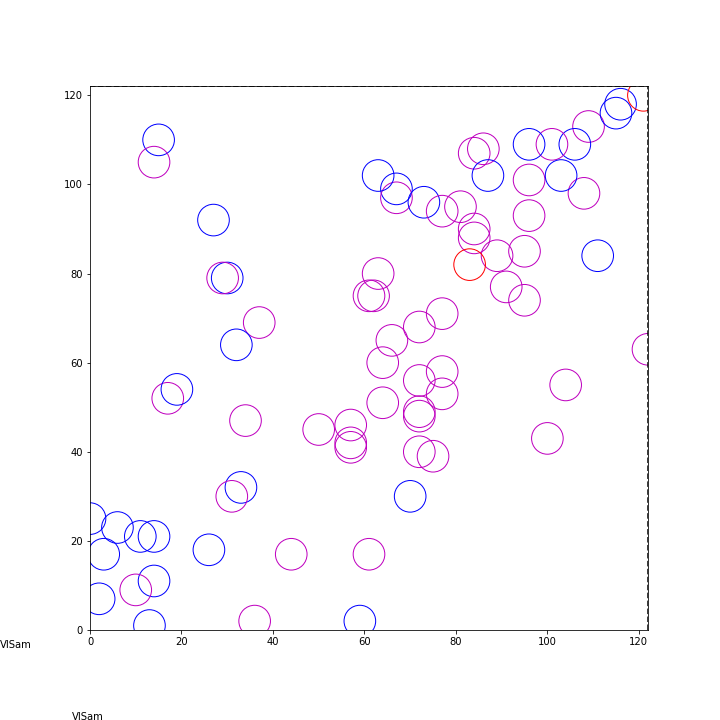

In [117]:
###################################################################################
#####################  Plot Static Weights  #######################################
###################################################################################
pair_colors = {}
min_n1 = min_n2 = None
max_n1 = max_n2 = None

if id_list is not None:
    plot_units = aggregate_units.loc[id_list]
    full_ids = aggregate_units.index.values
    n_convert = {np.where(full_ids == id)[0][0]:idx for idx,id in enumerate(id_list)}
else:
    #plot_units = aggregate_unit_info
    plot_units = aggregate_units
    n_convert = {i:i for i in range(len(plot_units))}


structures = aggregate_unit_info['ecephys_structure_acronym']
#structures = aggregate_units['ecephys_structure_acronym']
if plot_single_area:
    plot_struct_order = original_struct_order
    struct_counts = [sum(structures == s) for s in original_struct_order]
    start = 0
    for s_idx in range(len(structures)):
        s = original_struct_order[s_idx]
        if s == plot_single_area:
            break
        start += struct_counts[s_idx]
    min_n1 = min_n2 = start
    max_n1 = max_n2 = start + struct_counts[s_idx]
    

for pair_idx in range(len(aggregate_pairs)):
    n1, n2 = aggregate_pairs[pair_idx]
    u1_e = aggregate_units.iloc[n1]['waveform_duration'] > waveform_threshold 
    u2_e = aggregate_units.iloc[n2]['waveform_duration'] > waveform_threshold
    if u1_e and u2_e:
        pair_colors[(n1, n2)] = colors[0]
        pair_colors[(n2, n1)] = colors[0]
    elif u1_e and not u2_e:
        pair_colors[(n1, n2)] = colors[1]
        pair_colors[(n2, n1)] = colors[2]
    elif not u1_e and u2_e:
        pair_colors[(n1, n2)] = colors[2]
        pair_colors[(n2, n1)] = colors[1]
    elif not u1_e and not u2_e:
        pair_colors[(n1, n2)] = colors[3]
        pair_colors[(n2, n1)] = colors[3]

    
if plot_layer_info:
    if plot_single_area is not None:
        a_mask = plot_units['ecephys_structure_acronym'] == plot_single_area
        print("LAYERS FOR %s: "%plot_single_area, np.array(layer_ids)[a_mask])
        print("NUM UNITS: ",a_mask.sum())
else:
    layers = None
    print("NUM UNITS: ",len(aggregate_units))
    print("NUM PAIRS: ",len(aggregate_pairs))
    print("st wts: ",len(all_st_vals))
get_ipython().magic('matplotlib notebook')
fig_size = [10, 10]
fig, ax, plot_n_convert = plot_all_dyn_pairs_pts_static(aggregate_static_wts, aggregate_dyn_offsets, figsize=fig_size,
                                        max_size=max_size,
                                        structures=structures, structure_names=original_struct_order, struct_order=plot_struct_order,
                                        pair_colors=pair_colors,n_convert=n_convert,
                                        min_n1=min_n1, max_n1=max_n1, min_n2=min_n2, max_n2=max_n2,
                                        pair2stdynratio=pair2stdynratio,
                                        pair2maxdynval=pair2maxdynval,
                                        pair2maxdynoffset=pair2maxdynoffset,
                                        st_dyn_ratio_threshold=st_dyn_ratio_threshold,
                                        max_dyn_val_threshold=max_dyn_val_threshold,
                                        max_dyn_offset_threshold=max_dyn_offset_threshold,
                                        pairs=aggregate_pairs,
                                       )
fig.show()

In [118]:
#fig.savefig('static_all_VISp_full.png')

# Dynamic Connectivity

ALL WTS SHAPE:  (150, 77)


C:\Users\MNTL-VLASOV-ACCESS\.virtualenvs\ecephys_spike_sorting-master-5312NolF\lib\site-packages\ipykernel_launcher.py:531: RuntimeWarning: invalid value encountered in true_divide


<IPython.core.display.Javascript object>


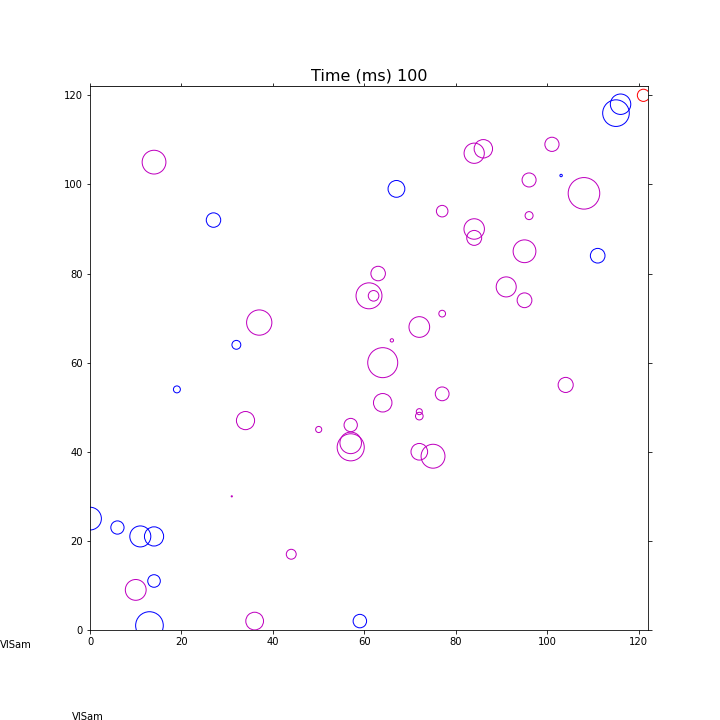

In [121]:
###################################################################################
#####################  Plot Dynamic Weights  #######################################
###################################################################################
max_size = 1000 #determines the maximum radius of a plotted point
avg_len = 5 # averaging in number of bins

plot_offsets = True #if True, the dynamic offset is plotted. If false, the total dynamic weight 
#(which is static weight + dynamic offset) is plotted

if plot_forward:
    plot_pairs = aggregate_pairs
else:
    plot_pairs = [[recv, send] for send, recv in aggregate_pairs]

fig_size = [10, 10]

anim = plot_all_dyn_pairs_pts_sig(aggregate_static_wts, aggregate_dyn_offsets, figsize=fig_size, only_offsets=False,
                       max_size=max_size, changing_only=False,
                       start_bin=5, start_time=-150, max_time=100,#in units of time bins, max_time=150,
                             avg_len=avg_len, avg_at_spikes=True, base_spikes_path=base_spikes_path,
                       structures=structures, structure_names=original_struct_order, struct_order=plot_struct_order,
                                  pair_colors=pair_colors,
                                 invert=invert, layers=layers,
                                 min_n1=min_n1, max_n1=max_n1, min_n2=min_n2, max_n2=max_n2,
                                 use_threshold_per_pair=use_threshold_per_pair, per_pair_threshold_ratio=per_pair_threshold_ratio,
                                 n_convert=n_convert, pair2session=pair2session, units=aggregate_units,
                                  id2localidx=id2localidx, shared_threshold=shared_threshold,
                                  plot_offsets=plot_offsets,
                                  pair2stdynratio=pair2stdynratio,
                                  pair2maxdynval=pair2maxdynval,
                                  pair2maxdynoffset=pair2maxdynoffset,
                                  st_dyn_ratio_threshold=st_dyn_ratio_threshold,
                                  max_dyn_val_threshold=max_dyn_val_threshold,
                                  max_dyn_offset_threshold=max_dyn_offset_threshold,
                                  plot_pairs=plot_pairs
                                 )
anim

In [36]:
dpi = 100
writergif = animation.PillowWriter(
        fps=60) 
anim.save('animation_VISam_offset_200.gif', writer=writergif, dpi = dpi)

In [15]:
#writer = animation.FFMpegWriter(
#     fps=60, bitrate=1800)
#anim.save("animation_VISp_offsets_400.mp4", writer=writer)

# Inspect individual pairs
## Note: Works only for a single session

In [84]:
#####THREE WAYS TO SPECIFY PAIR CHOICE#####
## Make sure to comment out the version you don't use ##

### Version 1: specify the index in the (filtered) units list
### these indices *should* correspond to the indices in the video above
#plot_n1, plot_n2 = 0, 5 #CHANGE THIS
#n1, n2 = plot_n_convert[plot_n1], plot_n_convert[plot_n2]
#id1, id2 = plot_units.index.values[n1], plot_units.index.values[n2] # look up id from index
### END VERSION 1

### Version 2: specify the pair index
#pair_idx = 3
#n1, n2 = aggregate_pairs[pair_idx]
#id1, id2 = plot_units.index.values[n1], plot_units.index.values[n2]
### END VERSION 2

### Version 3: specify the id of the neuron pair
id1, id2 = 950931566, 950929583 #CHANGE THIS
n1, n2 = np.nonzero(plot_units.index == id1)[0], np.nonzero(plot_units.index == id2)[0]
if len(n1) == 0:
    raise ValueError(f'Id {id1} not found in units table!')
if len(n2) == 0:
    raise ValueError(f'Id {id2} not found in units table!')
n1, n2 = n1[0], n2[0]
## END VERSION 3

pair_idx = np.where((aggregate_pairs[:, 0] == n1)*(aggregate_pairs[:, 1]==n2))[0]
if len(pair_idx) == 0:
    pair_idx = np.where((aggregate_pairs[:, 0] == n2)*(aggregate_pairs[:, 1]==n1))[0]
    if len(pair_idx) == 1:
        pair_idx = pair_idx[0]
        print("Note: this is the reverse direction for a significant pair (the forward direction is %d->%d)"%(plot_n2, plot_n1))
    else:
        raise ValueError('Pair not Found!')
else:
    pair_idx = pair_idx[0]

session = pair2session[(n1, n2)]
bin5_spikes_path = base_spikes_path % session
    
indn1, indn2 = np.array([n1, n2]).argsort()
all_n = sorted([n1, n2])

print('Pair ID: ', pair_idx)
print("N1N2 Local vals: ", n1,n2)
print("INDN snd rcv: ", indn1, indn2)
print("GLOB snd rcv: ", global2local[n1], global2local[n2])
print("IDs snd rcv: ", id1, id2)
current_unit_info = aggregate_unit_info.loc[[id1, id2]]
print("Stat Weight: ", all_st_vals[pair_idx])
print("Max dyn offset: ", all_dyn_offsets[pair_idx])
print("Max dyn weight: ", all_dyn_vals[pair_idx])
#current_unit_info


Pair ID:  3
N1N2 Local vals:  7 10
INDN snd rcv:  0 1
GLOB snd rcv:  49 34
IDs snd rcv:  950931566 950929583
Stat Weight:  0.3601536452770233
Max dyn offset:  0.3295904714227433
Max dyn weight:  0.6897441165102121


<IPython.core.display.Javascript object>


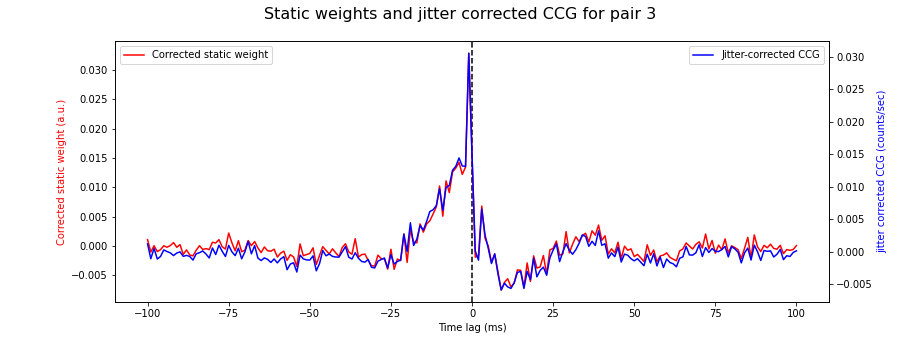

In [85]:
###########################################################################################################
###############  Plot and compare jitter-corrected CCG and statci weight for a given pair  ################
############################ for bin size = 1ms ###########################################################
bin_size = 1 #ms. If changing to 1ms bins need to change the directory to bin1_spikes_path 
# and change bins_size t0 0.001
max_len=100 #x-axis scale in bins
ccg_len=100

sp_1 = get_spikes_for_idx(bin1_spikes_path, global2local[n1])
sp_2 = get_spikes_for_idx(bin1_spikes_path, global2local[n2])
ccg = compute_ccg(sp_1, sp_2, ccg_len=ccg_len)
shuffled_ccg = compute_shuffled_ccg(sp_1, sp_2, ntrials=10, ccg_len=ccg_len, bin_size=bin_size)
corrected_ccg = ccg - shuffled_ccg

x = np.arange(-ccg_len*bin_size, ccg_len*bin_size+bin_size/2, bin_size)
x = x[ccg_len-max_len:ccg_len+max_len+2]
corrected_ccg = corrected_ccg[ccg_len-max_len:ccg_len+max_len+2]

allp_static_wts_1ms_path = os.path.join(model_1ms_dir, 'static_weights_val.npy')
allp_static_wts_1ms = np.load(allp_static_wts_1ms_path)[0]

c_allp_static_wts_1ms_path = os.path.join(model_1ms_dir, 'corrected_static_weights_val.npy')
c_allp_static_wts_1ms = np.load(c_allp_static_wts_1ms_path)[0]
wt_0to1 = allp_static_wts_1ms[global2local[n1], global2local[n2]]-c_allp_static_wts_1ms[global2local[n1], global2local[n2]]
wt_1to0 = allp_static_wts_1ms[global2local[n2], global2local[n1]]-c_allp_static_wts_1ms[global2local[n2], global2local[n1]]
wt_0to1 = np.flip(wt_0to1, (-1))

##########################PLot comparison #################################################

fig, ax = plt.subplots(figsize=[2*6.4, 4.8])
ax.axvline(0, linestyle='--', color='k')
#ax.axhline(0, linestyle='--', color='k')
ax.plot(range(0, (len(wt_1to0)-1)*bin_size+1, bin_size), wt_1to0, color='r',scaley=True)
ax.set_ylabel("Corrected static weight (a.u.)", color = 'r')
ax.plot(range(-(len(wt_0to1)-1)*bin_size, 1, bin_size), wt_0to1, color='r', label="Corrected static weight", scaley=True)
ax.legend(loc = 2)
ax2 = ax.twinx()
ax2.plot(x, corrected_ccg, color='b', label="Jitter-corrected CCG", scaley=True)
ax2.set_ylabel('jitter corrected CCG (counts/sec)', color = 'b')
ax.set_xlabel('Time lag (ms)')
ax2.legend(loc = 1)
fig.suptitle("Static weights and jitter corrected CCG for pair %d"%(pair_idx), fontsize=16)
fig.show()


In [99]:
df = pd.DataFrame(corrected_ccg,x)
df.to_csv('session_'+str(session)+'_pair'+str(pair_idx)+'_send'+str(n1)+
          '_recv'+str(n2)+'_corr_ccg_5ms.csv',sep='\t')

<IPython.core.display.Javascript object>


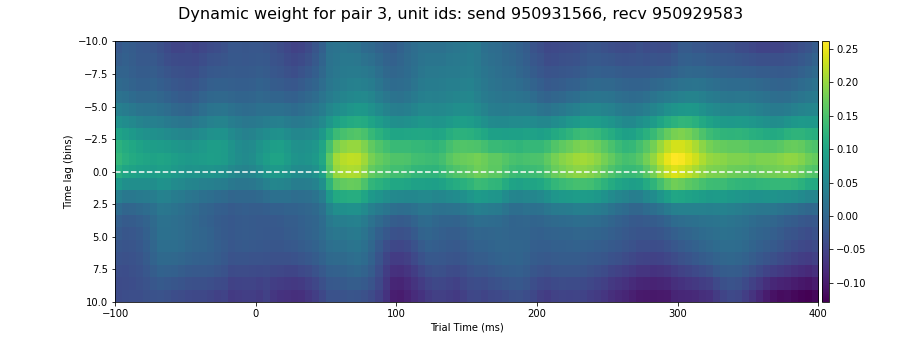

<IPython.core.display.Javascript object>


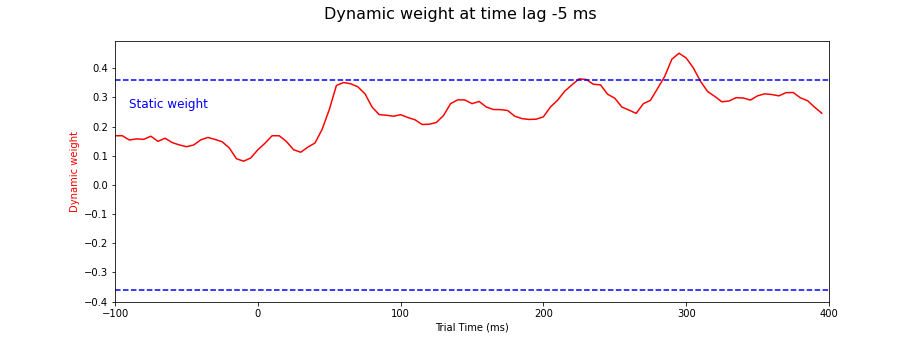

In [87]:
###################################################################################
#####################  Plot Dynamic Weights for a given pair  #####################
#####################  available only for 5ms bin_size  ###########################

#####################  Extra plot info   ###########################################
delay_ind = -1 #time lag (number of bins) for trial time value plot  - integer number of bins
delay_avg_len = 2 # smoothing along the time lag axis - number of bins, can be 1 and above
avg_len = 5 #smoothing along the trial time axis - integer number of bins
use_gaussian_delay_averaging = True

# These two values are converted into a bin index using the equations below. The minimum possible value is
# -150ms, and the maximum value is 1999ms
plot_start = -100 #trial time start in ms
plot_end = 400 #trial time stops ms
num_delays = 10 # number of time lags in bins

###################################### Do not change this ##########################################
####################  this determines the time of the first bin used for plotting purposes  ########
####################################################################################################
start_time=-150
bin_size=5
start_bin = (plot_start-start_time)//5
end_bin = (plot_end-start_time)//5
first_time = start_time + start_bin*bin_size
last_time = start_time + end_bin*bin_size
####################################################################################################

#################Calculate Dynamic weight for a given pair #####################################


allp_wts_im, allp_wt_f, allp_wt_b = get_wt_img_vals(bin5_spikes_path, n1, n2, num_delays, aggregate_static_wts, aggregate_dyn_offsets, 
                                                    start_time=start_time, bin_size=bin_size,
                                                    plot_start=plot_start, plot_end=plot_end,
                                                    avg_len=avg_len,
                                                    avg_at_spikes=True, static_convert=None,
                                                    normalize_across_time=True, use_wt_peak=True,
                                                   delay_avg_len=delay_avg_len,
                                                   use_gaussian_delay_averaging=use_gaussian_delay_averaging,
                                                  units=plot_units,
                                                  id2localidx=id2localidx)
run_allp_wts_sig = compute_sig_for_wts(aggregate_static_wts, n1, n2, allp_wts_im, allp_wt_f, allp_wt_b,
                                   static_convert=None,
                                   normalize_across_time=True, use_wt_peak=True, delay_ind=delay_ind,
                                      plot_std_units=False)


fig, ax = plt.subplots(figsize=[2*6.4, 4.8])
im = ax.imshow(allp_wts_im, extent=[first_time, last_time, num_delays, -num_delays], aspect='auto')
#im = ax.imshow(allp_wts_im[:11], extent=[first_time, last_time, 0, -10], aspect='auto')
ax.set_xlabel('Trial Time (ms)')
ax.set_ylabel('Time lag (bins)')
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="1%", pad=0.05)
fig.colorbar(im, cax=cax) #orientation='horizontal')
ax.plot([plot_start, plot_end], [0, 0], linestyle='--', color='w')
fig.suptitle("Dynamic weight for pair %d, unit ids: send %d, recv %d"%(pair_idx, id1, id2), fontsize=16)
, fontsize=16)
fig.show()


fig, ax = plt.subplots(figsize=[2*6.4, 4.8])
ln = ax.plot(np.arange(first_time, last_time, bin_size), run_allp_wts_sig, color='r')
ax.plot([plot_start, plot_end], [all_st_vals[pair_idx], all_st_vals[pair_idx]], linestyle='--', color='b')
ax.plot([plot_start, plot_end], [-all_st_vals[pair_idx], -all_st_vals[pair_idx]], linestyle='--', color='b')
ax.set_title('Static weight', loc='left', y=all_st_vals[pair_idx]*2, x=0.02, color='b')
ax.set_xlabel('Trial Time (ms)')
ax.set_ylabel('Dynamic weight', color='r')
ax.set_xlim(first_time, last_time)
fig.suptitle("Dynamic weight at time lag %d ms"%(delay_ind*bin_size), fontsize=16)
#ax.legend()
fig.show()


In [88]:
x1=np.arange(first_time, last_time, bin_size)
df = pd.DataFrame(x1, [run_allp_wts_sig])
df.to_csv('session_'+str(session)+'_pair'+str(pair_idx)+'_send'+str(n1)+
          '_recv'+str(n2)+'_delay'+str(delay_ind*bin_size)+"_dyn_weight.csv",sep='\t')


<IPython.core.display.Javascript object>


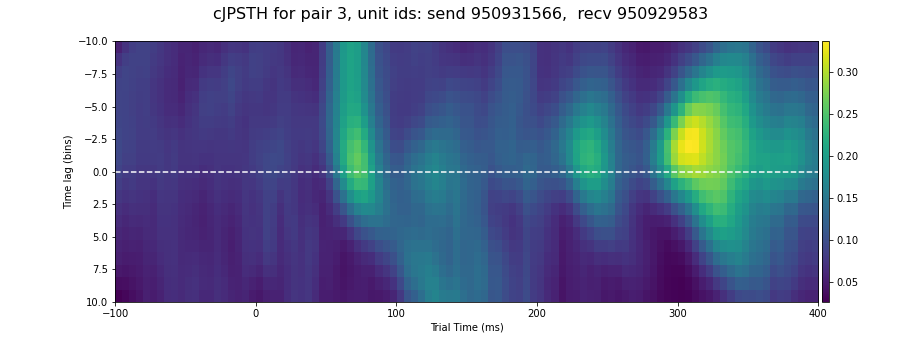

(21, 100)


<IPython.core.display.Javascript object>


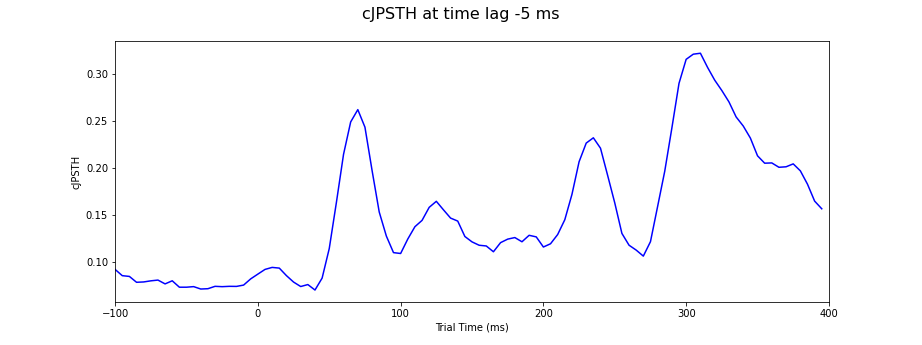

In [89]:
###################################################################################
#####################  Plot conditional cJPSTH for a given pair  ##################

################################## Arguments  #####################################
conditional=True # conditional if True

#####################  Extra plot info   #########################
delay_ind = delay_ind #time lag (number of bins) for trial time value plot  - integer number of bins
delay_avg_len = 2 # smoothing along time lag axis - number of bins, can be None
avg_len = avg_len # smoothing along trial time axis - integer number of bins
use_gaussian_delay_averaging = use_gaussian_delay_averaging
##################################################################

#################Calculate c-JPSTH #####################################

jpsth_im = get_jpsth_img_vals(bin5_spikes_path, global2local[n1], global2local[n2], num_delays, start_time=start_time, bin_size=bin_size,
                                  plot_start=plot_start, plot_end=plot_end,
                                  avg_len=avg_len,
                                  avg_at_spikes=True, static_convert=None,
                                  normalize_across_time=True, use_wt_peak=True, 
                                  val_only=False, delay_avg_len=delay_avg_len,
                                  use_gaussian_delay_averaging=use_gaussian_delay_averaging,
                                  conditional=conditional, corrected=False)
jpsth_sig = compute_sig_for_jpsth(jpsth_im, num_delays, normalize_across_time=True,
                                  use_wt_peak=True, #delay_offset=delay_offset)
                                  n1=global2local[n1], n2=global2local[n2], static_convert=None, static_wts=bin5_static_wts,
                                  delay_ind=delay_ind, plot_std_units=False)

fig, ax = plt.subplots(figsize=[2*6.4, 4.8])
print(jpsth_im.shape)
im = ax.imshow(jpsth_im, extent=[first_time, last_time, num_delays,-num_delays], aspect='auto')
#im = ax.imshow(jpsth_im[:11], extent=[first_time, last_time, 0,-10], aspect='auto')
ax.set_xlabel('Trial Time (ms)')
ax.set_ylabel('Time lag (bins)')
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="1%", pad=0.05)
fig.colorbar(im, cax=cax)
ax.plot([plot_start, plot_end], [0, 0], linestyle='--', color='w')
fig.suptitle("cJPSTH for pair %d, unit ids: send %d,  recv %d"%(pair_idx, id1, id2), fontsize=16)
fig.show()

fig, ax = plt.subplots(figsize=[2*6.4, 4.8])
ln = ax.plot(np.arange(first_time, last_time, bin_size), jpsth_sig, color='b')
ax.set_xlabel('Trial Time (ms)')
ax.set_ylabel('cJPSTH')
ax.set_xlim(first_time, last_time)
fig.suptitle("cJPSTH at time lag %d ms"%(delay_ind*bin_size), fontsize=16)
fig.show()

<IPython.core.display.Javascript object>


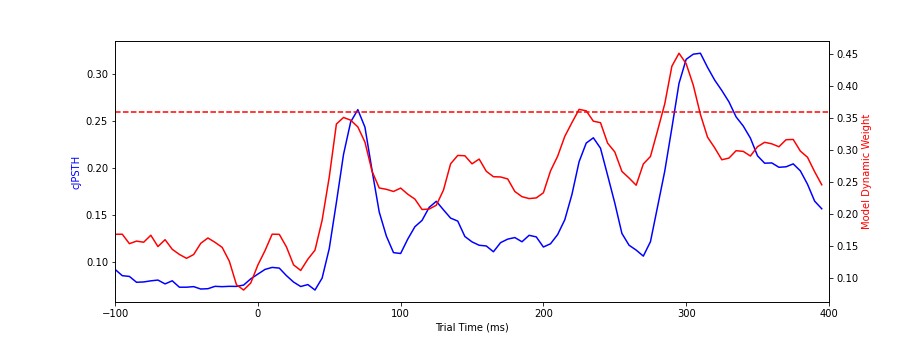

In [90]:
###################################################################################
#####################  Compare Dynamic Weights vs cJPSTH for a given pair  ########
###################################################################################
fig, [ax1, ax2] = plot_pred_and_jpsth_diag(run_allp_wts_sig, jpsth_sig, first_time, last_time, bin_size)


<IPython.core.display.Javascript object>


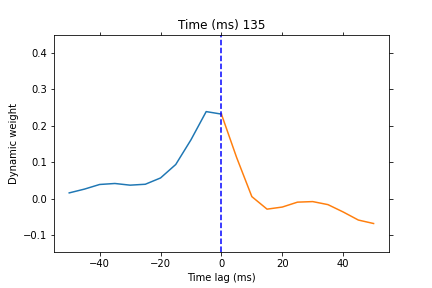

In [109]:
###################################################################################
#####################  Plot Dynamic weights vs time lags for a given pair  ########

anim = plot_single_pair_wt_vid(n1, n2, aggregate_static_wts, aggregate_dyn_offsets,
                               spikes_path=bin5_spikes_path,
                               start_time=-150, bin_size=5,
                               start_bin=0, avg_len=5,
                               avg_at_spikes=True, static_convert=None,
                               use_gaussian_delay_averaging=use_gaussian_delay_averaging,
                               normalize_across_time=True, use_wt_peak=True,
                               delay_avg_len=1,
                               interval=100, units=plot_units,
                                                  id2localidx=id2localidx)
anim

In [110]:
writergif = animation.PillowWriter(
        fps=10, bitrate=1800) 
anim.save('session_'+str(session)+'_pair'+str(pair_idx)+'_send'+str(n1)+'_recv'+str(n2)+'_anim_dyn.gif',
          writer=writergif, dpi = 300)

<IPython.core.display.Javascript object>


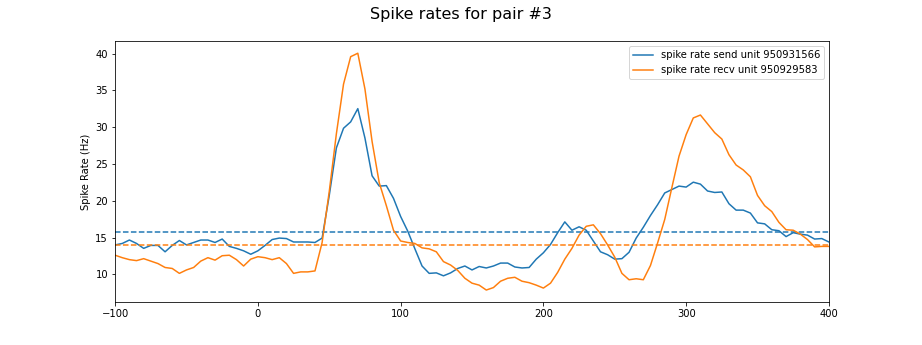

In [93]:
###################################################################################
#####################  Plot spike rates for a given pair  #########################
########################## Extra plot info ######################
# These two values are converted into a bin index using the equations below. The minimum possible value is
# -150, and the maximum value is 1999
plot_start = plot_start #trial time start in ms
plot_end = plot_end #trial time stops ms
avg_len=avg_len

###################################### Do not change this ##########################################
####################  this determines the time of the first bin used for plotting purposes  ########
####################################################################################################
start_time=-150
bin_size=5
start_bin = (plot_start-start_time)//5
end_bin = (plot_end-start_time)//5
first_time = start_time + start_bin*bin_size
last_time = start_time + end_bin*bin_size

####################################################################################################

sp1 = get_spikes_for_idx(bin5_spikes_path, global2local[n1], val_only=False)
sp2 = get_spikes_for_idx(bin5_spikes_path, global2local[n2], val_only=False)
sp1m = sp1.mean()/(bin_size*0.001)
sp2m = sp2.mean()/(bin_size*0.001)
sp1tm = sp1.mean(0)/(bin_size*0.001)
sp2tm = sp2.mean(0)/(bin_size*0.001)
if avg_len > 0:
    counts = np.ones(len(sp1tm))
    result1 = np.copy(sp1tm)
    result2 = np.copy(sp2tm)
    for idx in range(1, avg_len):
        result1[idx:] += sp1tm[:-idx]
        result2[idx:] += sp2tm[:-idx]
        counts[idx:] += 1
    sp1tm = result1 / counts
    sp2tm = result2/ counts
sp1tm = sp1tm[start_bin:end_bin+1]
sp2tm = sp2tm[start_bin:end_bin+1]

fig, ax = plt.subplots(figsize=[2*6.4, 4.8])
ax.plot(range(plot_start, plot_end+1, 5), sp1tm, label="spike rate send unit %d"%(id1))
ax.plot([plot_start, plot_end], [sp1m, sp1m], linestyle='--', color='C0')
ax.plot(range(plot_start, plot_end+1, 5), sp2tm, label="spike rate recv unit %d"%(id2))
ax.plot([plot_start, plot_end], [sp2m, sp2m], linestyle='--', color='C1')
ax.set_xlim(plot_start, plot_end)
ax.set_ylabel('Spike Rate (Hz)')
fig.suptitle("Spike rates for pair #%d"%(pair_idx), fontsize=16)
ax.legend()
fig.show()

In [94]:
x1=np.arange(plot_start, plot_end+1, bin_size)
df = pd.DataFrame(x1, [sp1tm, sp2tm])
df.to_csv('session_'+str(session)+'_pair'+str(pair_idx)+'_send'+str(n1)+
          '_recv'+str(n2)+'_rates.csv',sep='\t')

<IPython.core.display.Javascript object>


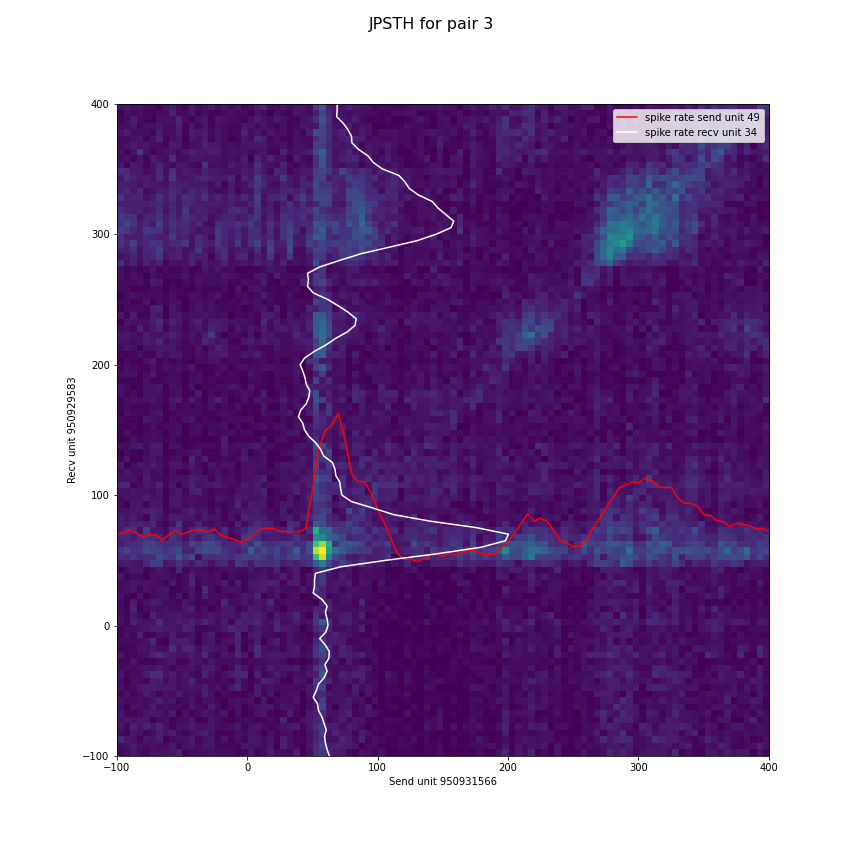

In [95]:
###################################################################################
#####################  Plot classical JPSTH for a given pair  ################################

sp_1 = get_spikes_for_idx(bin5_spikes_path, global2local[n1], val_only=False)[:, start_bin:end_bin]
sp_2 = get_spikes_for_idx(bin5_spikes_path, global2local[n2], val_only=False)[:, start_bin:end_bin]
jpsth = compute_jpsth(sp_1, sp_2, corrected = False).T
fig, ax = plt.subplots(figsize=(12, 12))
ax.imshow(jpsth, origin='lower', extent=[first_time, last_time,first_time, last_time])
ax.plot(range(plot_start, plot_end+1, 5), sp1tm*5, label="spike rate send unit %d"%(global2local[n1]), color='r')
ax.plot(sp2tm*5, range(plot_start, plot_end+1, 5), label="spike rate recv unit %d"%(global2local[n2]), color='w')
ax.set_xlim(plot_start, plot_end)
ax.set_ylabel('Recv unit %d'%(id2))
ax.set_xlabel('Send unit %d'%(id1))
fig.suptitle("JPSTH for pair %d"%(pair_idx), fontsize=16)
ax.legend()
fig.show()